# Load Libraries

In [1]:
import sys, os, pygmt, importlib, re, base64, glob
import numpy              as np
import pandas             as pd
import xarray             as xr
import xesmf              as xe
import netCDF4            as nc
import matplotlib.pyplot  as plt
import matplotlib.dates   as mdates
from matplotlib.offsetbox import AnchoredOffsetbox, VPacker, TextArea
from datetime             import timedelta, date, datetime
from pathlib              import Path
from dask.distributed     import Client, LocalCluster
from collections          import defaultdict
from scipy.interpolate    import interp1d
from pyproj               import CRS, Transformer
from IPython.display      import Image, HTML, Video
mod_path = '/home/581/da1339/AFIM/src/AFIM/src'
sys.path.insert(0, mod_path)
from sea_ice_toolbox      import SeaIceToolbox, SeaIceToolboxManager

## reload SeaIceToolbox if local changes have been made

In [3]:
import sys
import importlib
for mod in list(sys.modules):
    if mod.startswith("sea_ice_toolbox") or mod.startswith("sea_ice_"):
        del sys.modules[mod]
import sea_ice_plotter
import sea_ice_classification
import sea_ice_icebergs
import sea_ice_observations
import sea_ice_metrics
import sea_ice_toolbox
importlib.reload(sea_ice_plotter)
importlib.reload(sea_ice_classification)
importlib.reload(sea_ice_icebergs)
importlib.reload(sea_ice_observations)
importlib.reload(sea_ice_metrics)
importlib.reload(sea_ice_toolbox)
from sea_ice_toolbox import SeaIceToolbox

# [Simulation Table](https://dpath2o.github.io/AFIM/ice_diag_summary.html)

# [Methodology](https://dpath2o.github.io/AFIM/AFIM_sensitivity_methodology.html)

# ACCESS-OM2-025-ERA5 sea ice data ( **needs only to be run once, after which data can be extracted from local zarr files** )
+ this uses [ACCESS-NRI intake catalog](https://access-nri-intake-catalog.readthedocs.io/en/latest/index.html) through a ``SeaIceToolbox`` method ``load_ACCESS_OM_CICE``

In [2]:
dt0_str        = "2000-01-01"
dtN_str        = "2023-12-31"
dt_rng_str     = f"{dt0_str[:4]}-{dtN_str[:4]}"
ice_type       = "FI_BT"
SIA_dict       = {}
FIA_dict       = {}
SI_tools       = SeaIceToolbox(sim_name             = "AOM2-ERA5",
                               dt0_str              = dt0_str,
                               dtN_str              = dtN_str,
                               ice_speed_threshold  = 5e-4,
                               ice_speed_type       = "BT",
                               ice_type             = "FI_BT",
                               overwrite_zarr       = False,
                               save_new_figs        = True,
                               show_figs            = True,
                               overwrite_saved_figs = True)

2025-07-14 15:57:49,471 - INFO - log file initialised: /g/data/gv90/da1339/logs/SeaIceToolbox_AOM2-ERA5.log
2025-07-14 15:57:51,985 - INFO - Initialized new Dask client.
2025-07-14 15:57:51,987 - INFO - Dask distributed client can be accessed at url /proxy/8787/status
2025-07-14 15:57:51,988 - INFO - hemisphere initialised: SH


## load ACCESS-OM-025-ERA5 data from ESM datastore then convert to zarr files for easy of use later
+ loading and saving only needs to be done if it has not been done previously
+ running both of these cells takes approximately an hour with the bottleneck at writing to zarr

In [3]:
AOM2 = SI_tools.load_ACCESS_OM_CICE()


--> The keys in the returned dictionary of datasets are constructed as follows:
	'file_id.frequency'


2025-07-14 16:03:19,658 - INFO - Extracting variables from ESM datastore: ['aice', 'congel', 'dvidtd', 'dvidtt', 'frazil', 'hi', 'tarea', 'uarea', 'uvel', 'vvel']


In [4]:
SI_tools.write_ACCESS_to_monthly_zarr(AOM2)

2025-07-14 16:03:21,801 - INFO - First timestamp now: 1999-12-31 00:00:00
2025-07-14 16:03:21,803 - INFO - Shifted all timestamps back by one day to correct for CICE daily average label.
2025-07-14 16:03:22,070 - INFO - Skipping /g/data/gv90/da1339/afim_output/AOM2-ERA5/zarr/iceh_1999-12.zarr (already exists)
2025-07-14 16:03:22,334 - INFO - Skipping /g/data/gv90/da1339/afim_output/AOM2-ERA5/zarr/iceh_2000-01.zarr (already exists)
2025-07-14 16:03:22,561 - INFO - Skipping /g/data/gv90/da1339/afim_output/AOM2-ERA5/zarr/iceh_2000-02.zarr (already exists)
2025-07-14 16:03:22,795 - INFO - Skipping /g/data/gv90/da1339/afim_output/AOM2-ERA5/zarr/iceh_2000-03.zarr (already exists)
2025-07-14 16:03:23,028 - INFO - Skipping /g/data/gv90/da1339/afim_output/AOM2-ERA5/zarr/iceh_2000-04.zarr (already exists)
2025-07-14 16:03:23,248 - INFO - Skipping /g/data/gv90/da1339/afim_output/AOM2-ERA5/zarr/iceh_2000-05.zarr (already exists)
2025-07-14 16:03:23,484 - INFO - Skipping /g/data/gv90/da1339/afim_ou

## run ACCESS-OM-025-ERA5 through fast ice classification workflow
+ this is a quick process and will save masked zarr dataset

In [ ]:
AOM2_FI_raw = SI_tools.process_daily_cice(ispd_thresh=5e-4,
                                          ivec_type="BT",
                                          overwrite_zarr_group=True)

In [ ]:
AOM2_FI_roll = SI_tools.process_rolling_cice(ispd_thresh=5e-4,
                                             ivec_type="BT",
                                             overwrite_zarr_group=True)

# <span style="color: red;">Study Objectives</span>

# Can a realistic simulation of circumpolar Antarctic fast ice be achieved in CICE-standalone?

+ Sea ice area and volum comparisons are done against [NSIDC](https://nsidc.org/data/g02202/versions/4) and [ACCESS-OM2-025-IAF-ERA](https://forum.access-hive.org.au/t/era-5-forced-access-om2-simulations/1103) (``AOM2-ERA``). The rationale is to show two of my simulations ([AFIM](https://github.com/dpath2o/AFIM), *CICE6-standalone*) against both NSIDC and ACCESS-OM2 as a relative overall gauge of AFIM performance.

+ I've chosen two related AFIM simulations: ``elps-min`` and ``gi-nil``. Both of which have ellispse eccentrincities ($e_{f}=e_{g}=1.2$, and further just abbreviated $e$) and tensile stress parameter ($k_{t}=0.2$) and all other CICE namelist parameters set to *default* standalone configuration, with the exception of the landmask file used (``kmt_file``). ``elps-min`` uses a modified landmask where 25% of the non-isolated grounded iceberg cells remain, whereas ``gi-nil`` uses the same landmask file as ``AOM2-ERA5`` and hence has no grounded iceberg cells.
  
+ Animations of daily sea ice speed ($\sqrt{u^2 + v^2}$) are then shown of the above two AFIM simulations along with AOM2-ERA5 for the same period (Austral winter 1999). Implicitly, the animations show the effect of $e$ and $ktens$ on the coastal icepack, and for the ``elps-min`` simulation the animation clearly shows the significance of grouned icebergs. 

# Southern Ocean Pack/Fast Ice Area, Volume, Thickness and Drift/Speed Comparisons

In [3]:
sim_names                     = ["gi-nil-def","elps-min","ry93","AOM2-ERA5"]
dt0_str                       = "1994-01-01"
dtN_str                       = "1999-12-31"
SI_growth_days                = (110,200)
SI_retreat_days1              = (330,360)
SI_retreat_days2              = (1,60)
PI_stats                      = {}
FI_stats                      = {}
P_log                         = Path(Path.home(), "logs", "paper1_SO_SIA.log")
SI_tool_mgr                   = SeaIceToolboxManager(P_log=P_log)
SI_tools                      = SeaIceToolbox(sim_name = "__dummy__")
G_CMEMS                       = xr.open_dataset("/g/data/gv90/da1339/grids/GLORYS/CMEMS_0p25_grid.nc").rename_dims({'x':'longitude','y':'latitude'})
CMEMS_SI                      = xr.open_mfdataset("/g/data/gv90/da1339/SeaIce/CMEMS/0p25/daily/199*_CMEMS_org.nc")
G_CMEMS_SO                    = G_CMEMS.isel(latitude=slice(0,340))
CMEMS_SI_SO                   = CMEMS_SI.isel(latitude=slice(0,340))
PI_stats['CMEMS-ORAS']        = {}
PI_stats['ESA_CCI']           = {}
PI_stats['NSIDC']             = {}
PI_stats['CMEMS-ORAS']['SIA'] = SI_tools.compute_ice_area(CMEMS_SI_SO['siconc_oras'], G_CMEMS_SO['area'], ice_area_scale=1e6, spatial_dim_names=("latitude","longitude"))
PI_stats['CMEMS-ORAS']['SIV'] = SI_tools.compute_ice_volume(CMEMS_SI_SO['siconc_oras'], CMEMS_SI_SO['sithick_oras'], G_CMEMS_SO['area'], ice_volume_scale=1e6, spatial_dim_names=("latitude","longitude"))
PI_stats['CMEMS-ORAS']['SIT'] = SI_tools.compute_ice_thickness(CMEMS_SI_SO['sithick_oras'], CMEMS_SI_SO['siconc_oras'], G_CMEMS_SO['area'], spatial_dim_names=("latitude","longitude"))
SIT_comps                     = xr.open_mfdataset("/g/data/gv90/da1339/afim_output/elps-min/SIT_elps-min_*.nc")
PI_stats['ESA_CCI']['SIT']    = SIT_comps['SIT_obs']
NSIDC                         = SI_tools.compute_NSIDC_metrics()
PI_stats['NSIDC']['SIA']      = NSIDC['SIA']
for sim in sim_names:
    print(f"\n\nprocessing {sim}")
    PI_stats[sim]               = {}
    FI_stats[sim]               = {}
    SI_tools                    = SeaIceToolbox(sim_name = sim, dt0_str=dt0_str, dtN_str=dtN_str)
    FId, CICE_org               = SI_tools.load_processed_cice( zarr_CICE = True )
    CICE_SO                     = CICE_org.isel(nj=SI_tools.hemisphere_dict['nj_slice'])
    PI_stats[sim]['SIA']        = SI_tools.compute_ice_area(CICE_SO['aice'], CICE_SO['tarea'], ice_area_scale=SI_tools.SIC_scale)
    PI_stats[sim]['SIV']        = SI_tools.compute_ice_volume(CICE_SO['aice'], CICE_SO['hi'], CICE_SO['tarea'])
    PI_stats[sim]['SIT']        = SI_tools.compute_ice_thickness(CICE_SO['hi'], CICE_SO['aice'], CICE_SO['tarea'])
    PI_stats[sim]['SIA_season'] = SI_tools.compute_seasonal_statistics(PI_stats[sim]['SIA'], 
                                                                       growth_range        = SI_growth_days,
                                                                       retreat_early_range = SI_retreat_days1,
                                                                       retreat_late_range1 = SI_retreat_days1,
                                                                       retreat_late_range2 = SI_retreat_days2)
    PI_stats[sim]['SIV_season'] = SI_tools.compute_seasonal_statistics(PI_stats[sim]['SIV'], 
                                                                       growth_range        = SI_growth_days,
                                                                       retreat_early_range = SI_retreat_days1,
                                                                       retreat_late_range1 = SI_retreat_days1,
                                                                       retreat_late_range2 = SI_retreat_days2)
    PI_stats[sim]['SIA_skills'] = SI_tools.compute_skill_statistics(PI_stats[sim]['SIA'], PI_stats['NSIDC']['SIA'])
    FI_bool                     = SI_tools.boolean_fast_ice( FId['FI_mask'] )
    aice_bool                   = CICE_SO['aice'].where(FI_bool)
    hi_bool                     = CICE_SO['hi'].where(FI_bool)
    tarea_bool                  = CICE_SO['tarea'].where(FI_bool)
    FI_stats[sim]['FIA']        = SI_tools.compute_ice_area(FI_bool, tarea_bool)
    FI_stats[sim]['FIV']        = SI_tools.compute_ice_volume(FI_bool, hi_bool, tarea_bool)
    FI_stats[sim]['FIT']        = SI_tools.compute_ice_thickness(hi_bool, FI_bool, tarea_bool)
    AF_clim                     = SI_tools.load_AF2020_FIA_summary(start="1994-01-01", end="1999-12-31")
    obs_fia                     = SI_tools.AF2020_clim_to_model_time(FI_stats[sim]['FIA'] ,
                                                                     AF_clim["FIA_clim"].sel(region="circumpolar") )
    FI_stats[sim]['FIA_stats']  = SI_tools.compute_skill_statistics(FI_stats[sim]['FIA'] , obs_fia )

2025-07-21 12:24:58,109 - INFO - hemisphere initialised: SH
INFO:__dummy__:hemisphere initialised: SH
2025-07-21 12:24:58,112 - INFO - reading /g/data/gv90/da1339/afim_output/__dummy__/ice_diag.d to construct /g/data/gv90/da1339/afim_output/__dummy__/ice_in_AFIM_subset___dummy__.json
INFO:__dummy__:reading /g/data/gv90/da1339/afim_output/__dummy__/ice_diag.d to construct /g/data/gv90/da1339/afim_output/__dummy__/ice_in_AFIM_subset___dummy__.json
2025-07-21 12:24:58,237 - INFO - 0.00 m^2 total circumpolar grounded iceberg area for __dummy__
INFO:__dummy__:0.00 m^2 total circumpolar grounded iceberg area for __dummy__
2025-07-21 12:24:58,238 - INFO - spatially-integrating the product of sea ice concentrations and grid cell areas
INFO:__dummy__:spatially-integrating the product of sea ice concentrations and grid cell areas
2025-07-21 12:24:58,262 - INFO - 0.00 m² total grounded iceberg area for __dummy__
INFO:__dummy__:0.00 m² total grounded iceberg area for __dummy__
2025-07-21 12:24:58,



processing gi-nil-def


2025-07-21 12:25:55,648 - INFO - Loaded FI_BT: 2191 time steps from 72 files
INFO:gi-nil-def:Loaded FI_BT: 2191 time steps from 72 files
2025-07-21 12:25:55,652 - INFO - Memory after Zarr load: 19.8% used
INFO:gi-nil-def:Memory after Zarr load: 19.8% used
2025-07-21 12:25:55,653 - INFO - Load monthly iceh_*.zarr files between 1994-01-01 and 1999-12-31
INFO:gi-nil-def:Load monthly iceh_*.zarr files between 1994-01-01 and 1999-12-31
2025-07-21 12:25:55,671 - INFO - Found 72 zarr files
INFO:gi-nil-def:Found 72 zarr files
2025-07-21 12:26:24,563 - INFO - 0.00 m^2 total circumpolar grounded iceberg area for gi-nil-def
INFO:gi-nil-def:0.00 m^2 total circumpolar grounded iceberg area for gi-nil-def
2025-07-21 12:26:24,565 - INFO - spatially-integrating the product of sea ice concentrations and grid cell areas
INFO:gi-nil-def:spatially-integrating the product of sea ice concentrations and grid cell areas
2025-07-21 12:26:24,583 - INFO - 0.00 m² total grounded iceberg area for gi-nil-def
INFO:g



processing elps-min


2025-07-21 12:28:44,026 - INFO - searching for files between 1994-01-01 00:00:00 and 1999-12-31 00:00:00 in /g/data/gv90/da1339/afim_output/elps-min/zarr/ispd_thresh_5.0e-4
INFO:elps-min:searching for files between 1994-01-01 00:00:00 and 1999-12-31 00:00:00 in /g/data/gv90/da1339/afim_output/elps-min/zarr/ispd_thresh_5.0e-4
2025-07-21 12:28:44,130 - INFO - Found 72 zarr files
INFO:elps-min:Found 72 zarr files
2025-07-21 12:29:49,451 - INFO - Loaded FI_BT: 2191 time steps from 72 files
INFO:elps-min:Loaded FI_BT: 2191 time steps from 72 files
2025-07-21 12:29:49,456 - INFO - Memory after Zarr load: 19.9% used
INFO:elps-min:Memory after Zarr load: 19.9% used
2025-07-21 12:29:49,458 - INFO - Load monthly iceh_*.zarr files between 1994-01-01 and 1999-12-31
INFO:elps-min:Load monthly iceh_*.zarr files between 1994-01-01 and 1999-12-31
2025-07-21 12:29:49,476 - INFO - Found 72 zarr files
INFO:elps-min:Found 72 zarr files
2025-07-21 12:30:20,330 - INFO - 66791608021.64 m^2 total circumpolar 



processing ry93


2025-07-21 12:32:49,179 - INFO - searching for files between 1994-01-01 00:00:00 and 1999-12-31 00:00:00 in /g/data/gv90/da1339/afim_output/ry93/zarr/ispd_thresh_5.0e-4
INFO:ry93:searching for files between 1994-01-01 00:00:00 and 1999-12-31 00:00:00 in /g/data/gv90/da1339/afim_output/ry93/zarr/ispd_thresh_5.0e-4
2025-07-21 12:32:49,270 - INFO - Found 72 zarr files
INFO:ry93:Found 72 zarr files
2025-07-21 12:34:00,066 - INFO - Loaded FI_BT: 2191 time steps from 72 files
INFO:ry93:Loaded FI_BT: 2191 time steps from 72 files
2025-07-21 12:34:00,069 - INFO - Memory after Zarr load: 23.9% used
INFO:ry93:Memory after Zarr load: 23.9% used
2025-07-21 12:34:00,071 - INFO - Load monthly iceh_*.zarr files between 1994-01-01 and 1999-12-31
INFO:ry93:Load monthly iceh_*.zarr files between 1994-01-01 and 1999-12-31
2025-07-21 12:34:00,089 - INFO - Found 72 zarr files
INFO:ry93:Found 72 zarr files
2025-07-21 12:34:35,384 - INFO - 38098814849.39 m^2 total circumpolar grounded iceberg area for ry93
I



processing AOM2-ERA5


2025-07-21 12:37:15,119 - INFO - searching for files between 1994-01-01 00:00:00 and 1999-12-31 00:00:00 in /g/data/gv90/da1339/afim_output/AOM2-ERA5/zarr/ispd_thresh_5.0e-4
INFO:AOM2-ERA5:searching for files between 1994-01-01 00:00:00 and 1999-12-31 00:00:00 in /g/data/gv90/da1339/afim_output/AOM2-ERA5/zarr/ispd_thresh_5.0e-4
2025-07-21 12:37:15,182 - INFO - Found 72 zarr files
INFO:AOM2-ERA5:Found 72 zarr files
2025-07-21 12:38:30,517 - INFO - Loaded FI_BT: 2190 time steps from 72 files
INFO:AOM2-ERA5:Loaded FI_BT: 2190 time steps from 72 files
2025-07-21 12:38:30,520 - INFO - Memory after Zarr load: 25.7% used
INFO:AOM2-ERA5:Memory after Zarr load: 25.7% used
2025-07-21 12:38:30,522 - INFO - Load monthly iceh_*.zarr files between 1994-01-01 and 1999-12-31
INFO:AOM2-ERA5:Load monthly iceh_*.zarr files between 1994-01-01 and 1999-12-31
2025-07-21 12:38:30,547 - INFO - Found 72 zarr files
INFO:AOM2-ERA5:Found 72 zarr files
2025-07-21 12:39:05,016 - INFO - 0.00 m^2 total circumpolar gr

In [8]:
def plot_climatology_with_envelope(PI_stats, var, ylabel, save_name, exclude_keys=None, color_dict=None):
    """
    Plot climatological mean and min-max envelope for a given sea ice variable.
    
    Parameters
    ----------
    PI_stats : dict
        Dictionary containing xarray DataArrays with 'time' coordinate.
    var : str
        Variable key to plot (e.g., 'SIA', 'SIV', 'SIT').
    ylabel : str
        Y-axis label for the plot.
    save_name : str
        Filename to save the figure to (just the base name, no path).
    exclude_keys : list, optional
        Keys in PI_stats to skip plotting.
    color_dict : dict, optional
        Optional dictionary mapping simulation keys to consistent colours.
    """
    if exclude_keys is None:
        exclude_keys = []
    if color_dict is None:
        color_dict = {}
    doy_ticks    = [15, 46, 75, 106, 136, 167, 197, 228, 259, 289, 320, 350]
    month_labels = pd.to_datetime(doy_ticks, format='%j').strftime('%b')
    plt.figure(figsize=(20, 12))
    for key in PI_stats:
        if key in exclude_keys or var not in PI_stats[key]:
            continue
        dt = pd.to_datetime(PI_stats[key][var]["time"].values)
        PI_stats[key][var].coords['doy'] = ('time', dt.dayofyear)
        data      = PI_stats[key][var].assign_coords(doy=PI_stats[key][var]['doy'])
        clim_mean = data.groupby('doy').mean('time')
        clim_min  = data.groupby('doy').min('time')
        clim_max  = data.groupby('doy').max('time')
        color     = color_dict.get(key, None)
        if key in color_dict:
            color = color_dict[key]
            plt.plot(clim_mean['doy'], clim_mean, label=key, lw=2, color=color)
            plt.fill_between(clim_mean['doy'].values, clim_min.values, clim_max.values, alpha=0.2, color=color)
        else:
            plt.plot(clim_mean['doy'], clim_mean, label=key, lw=2)
            plt.fill_between(clim_mean['doy'].values, clim_min.values, clim_max.values, alpha=0.2 )
    plt.xticks(doy_ticks, month_labels, fontsize=18)
    plt.yticks(fontsize=18)
    plt.xlabel("Month", fontsize=24)
    plt.ylabel(ylabel, fontsize=24)
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.legend(fontsize=18)
    plt.tight_layout()
    out_path = Path(Path.home(),"graphical","AFIM","timeseries",save_name)
    plt.savefig(out_path)
    plt.show()


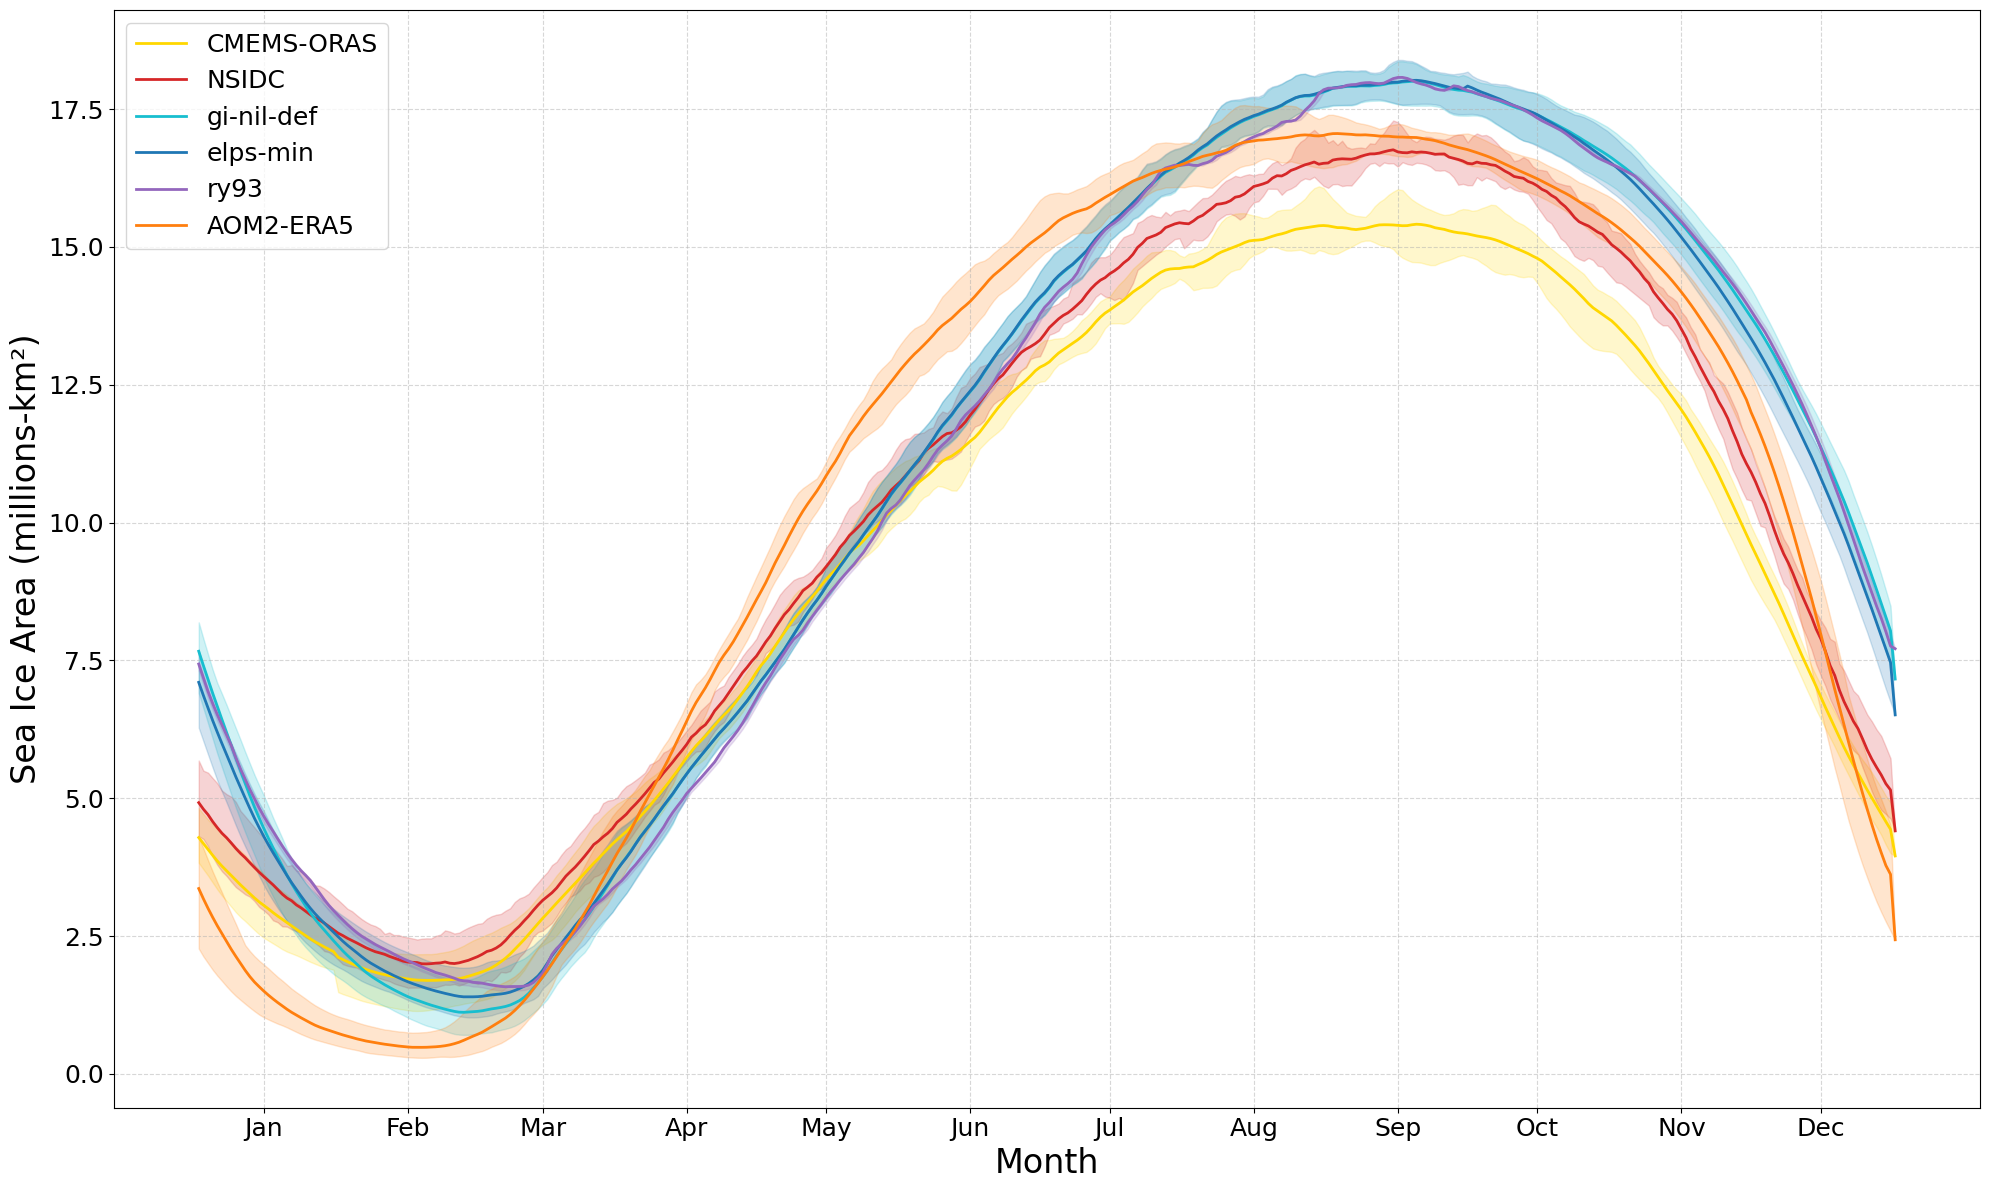

In [9]:
color_dict = {"gi-nil-def" : "tab:cyan",
              "elps-min"   : "tab:blue",
              "ry93"       : "tab:purple",
              "AOM2-ERA5"  : "tab:orange",
              "CMEMS-ORAS" : "gold",
              "NSIDC"      : "tab:red",
              "ESA_CCI"    : "tab:red"}
plot_climatology_with_envelope(
    PI_stats,
    var="SIA",
    ylabel="Sea Ice Area (millions-km²)",
    save_name="SIA_comparison_paper1_fig1.png",
    exclude_keys=["ESA_CCI"],
    color_dict=color_dict
)

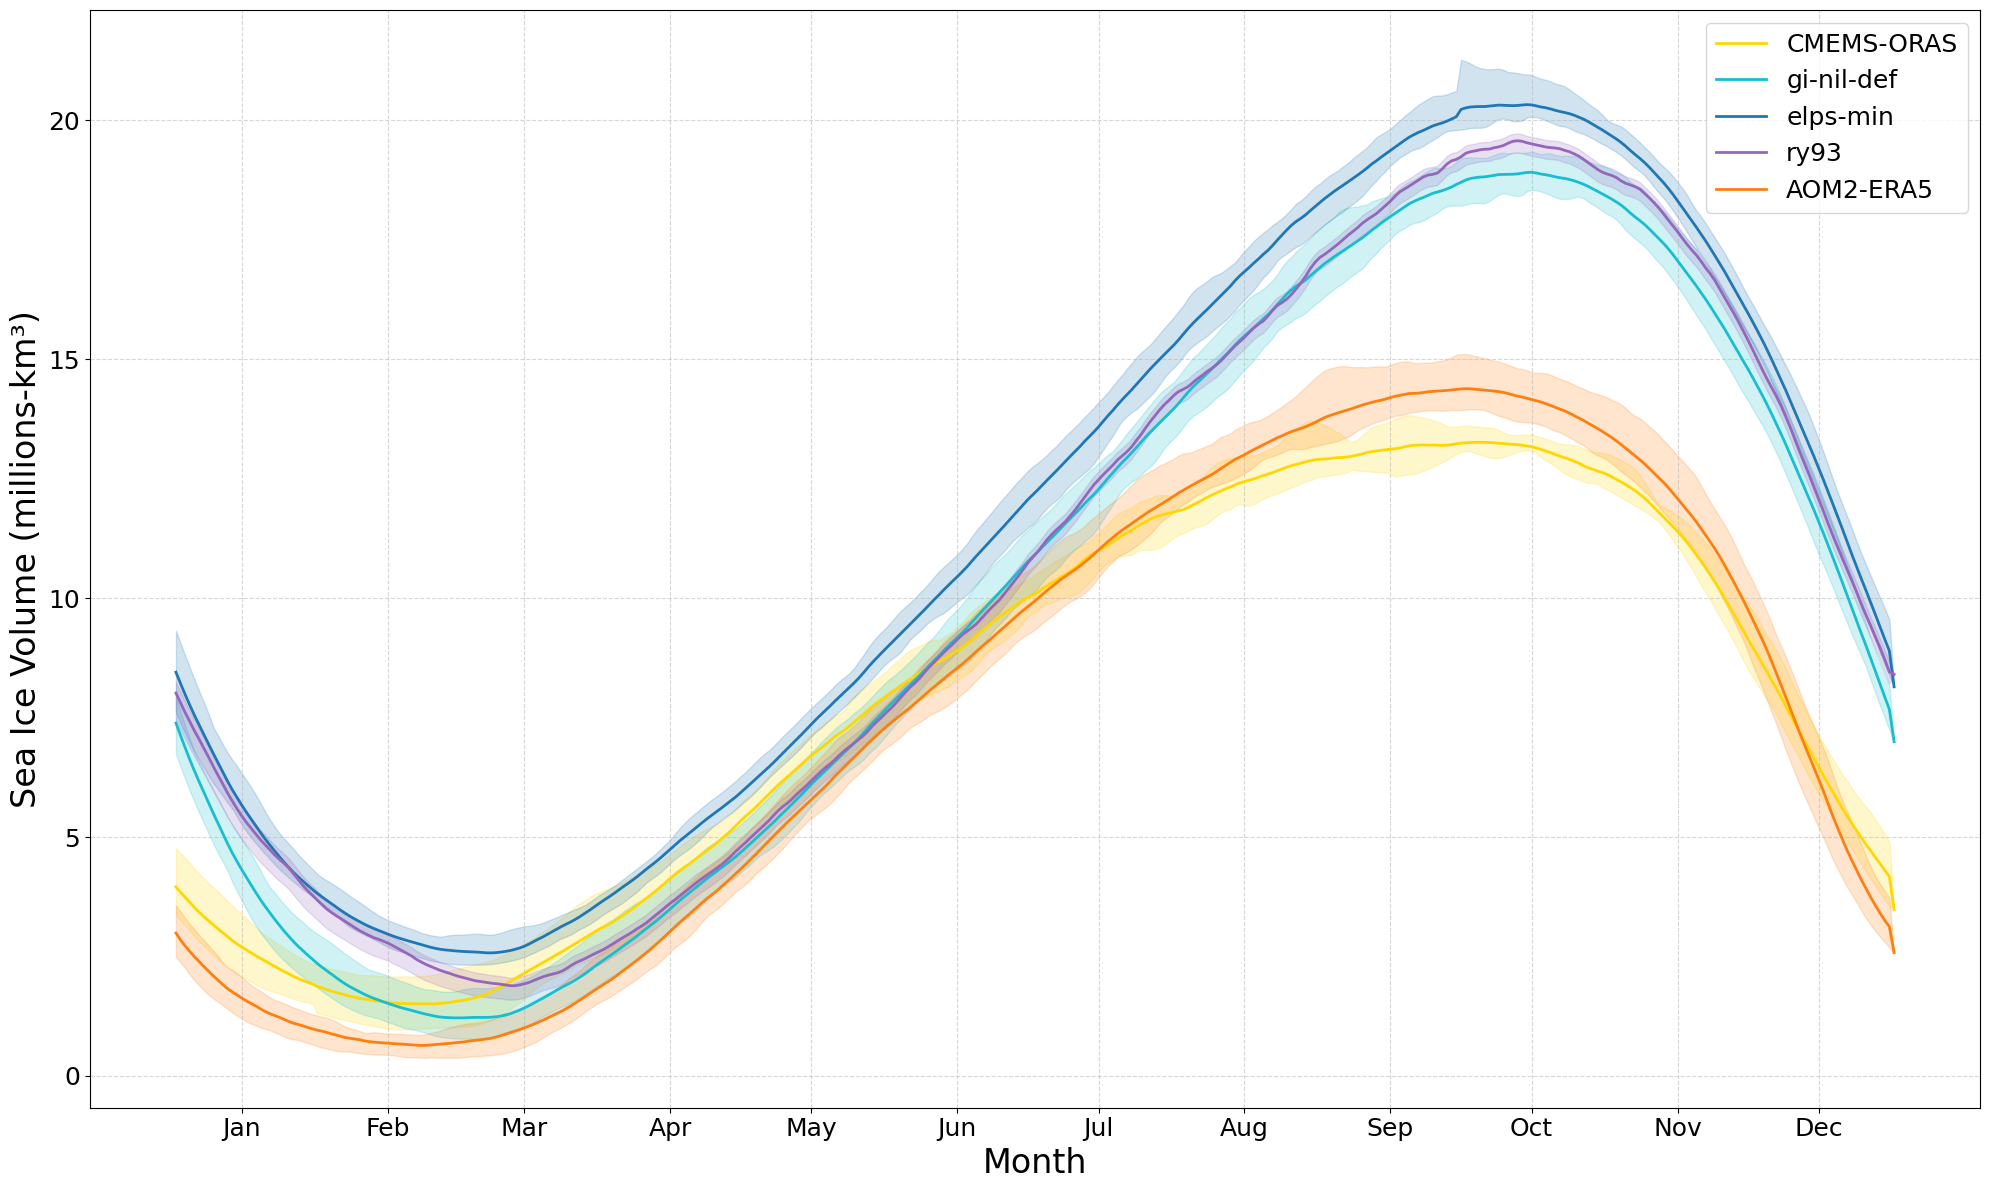

In [10]:
plot_climatology_with_envelope(
    PI_stats,
    var="SIV",
    ylabel="Sea Ice Volume (millions-km³)",
    save_name="SIV_comparison_paper1_fig1.png",
    exclude_keys=["NSIDC", "ESA_CCI"],
    color_dict=color_dict
)

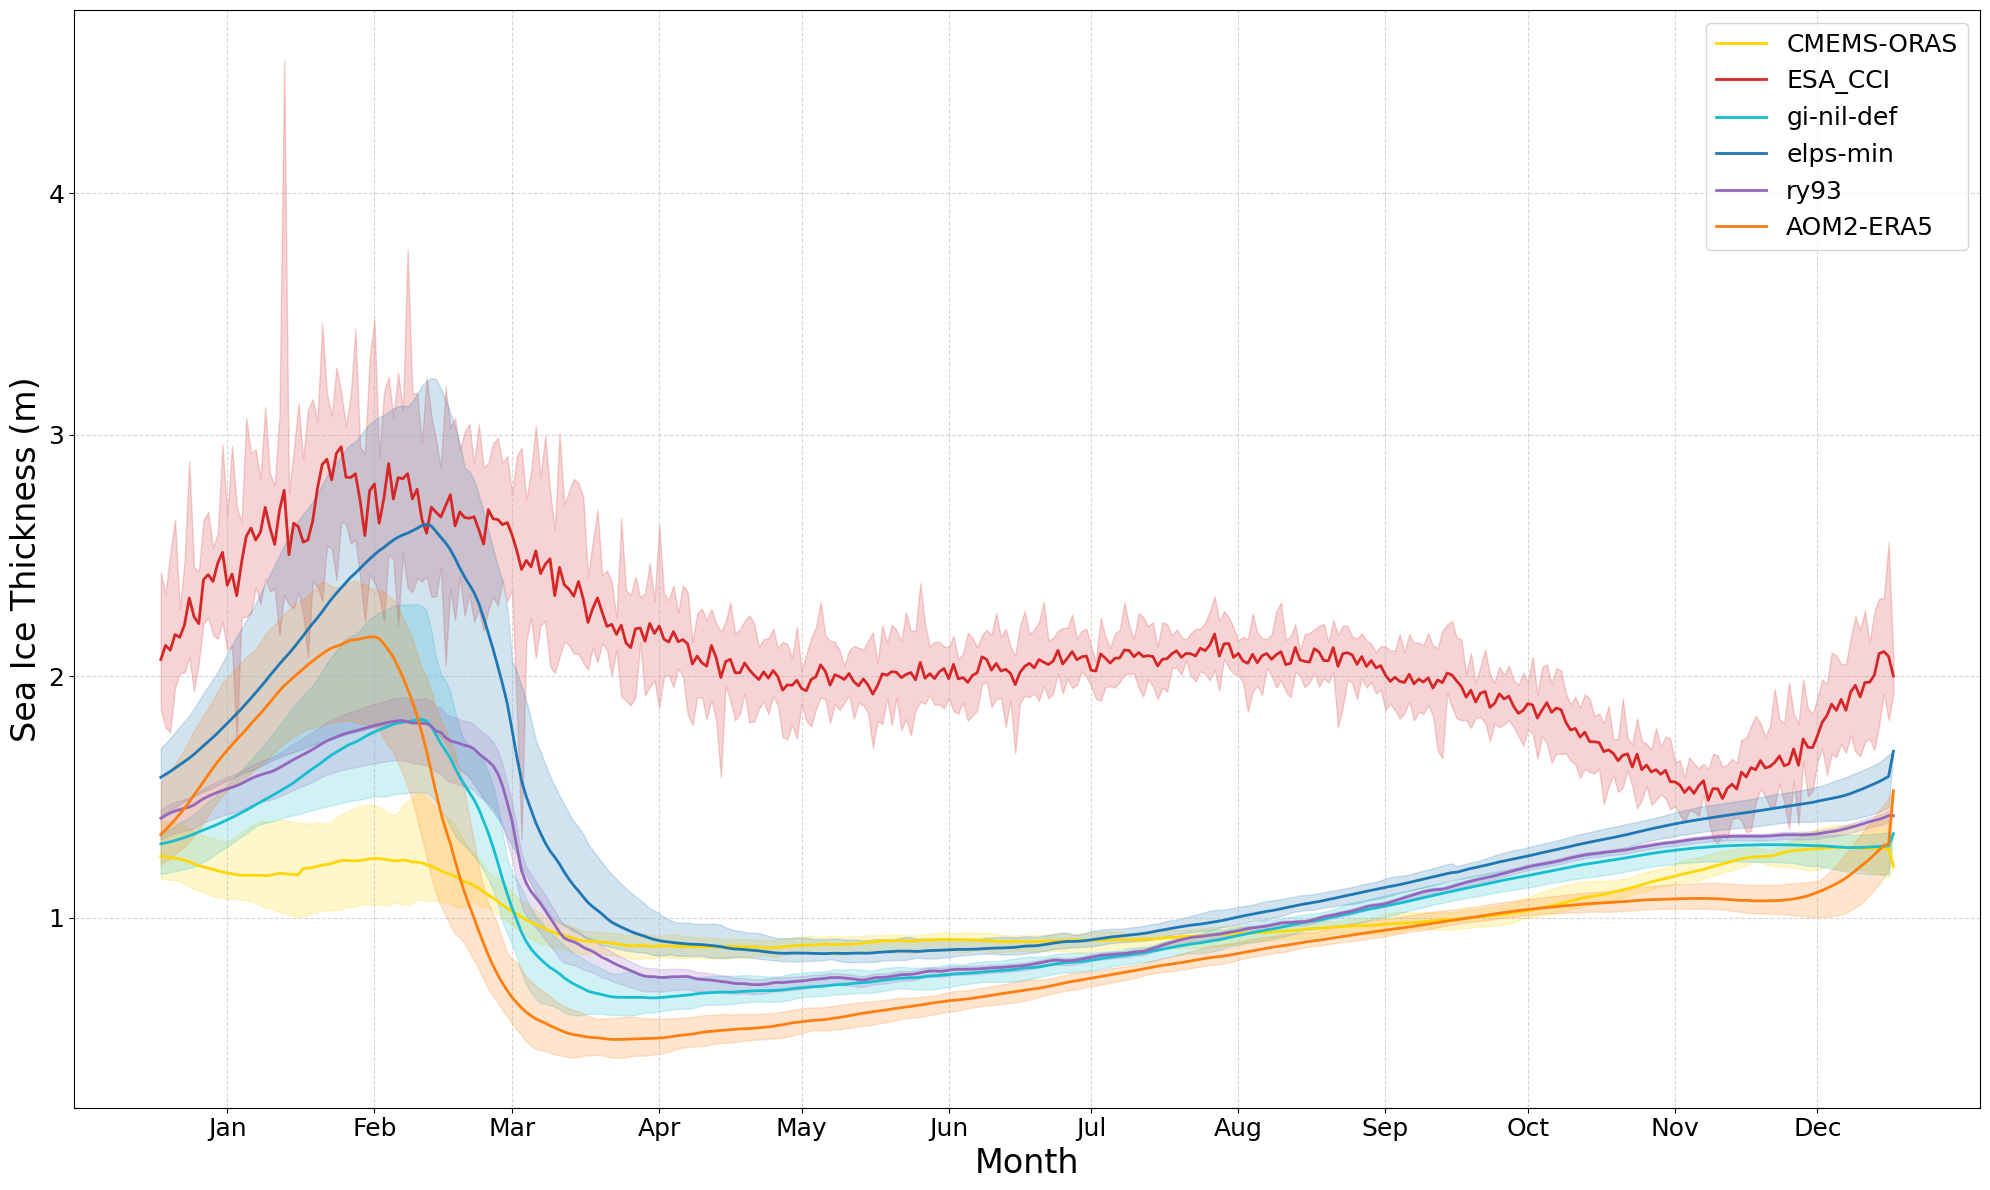

In [11]:
plot_climatology_with_envelope(
    PI_stats,
    var="SIT",
    ylabel="Sea Ice Thickness (m)",
    save_name="SIT_comparison_paper1_fig1.png",
    exclude_keys=["NSIDC"],
    color_dict=color_dict
)

In [12]:
def plot_continuous_timeseries_with_optional_climatology(
    PI_stats,
    var,
    ylabel,
    save_name,
    exclude_keys=None,
    color_dict=None,
    repeat_climatology_key=None,
    model_years=None
):
    """
    Plot continuous time series for each key, with option to repeat a climatology across years.
    
    Parameters
    ----------
    PI_stats : dict of xarray DataArrays
        Must include 'time' coordinate for each variable.
    var : str
        One of 'SIA', 'SIV', or 'SIT'.
    ylabel : str
        Y-axis label for the plot.
    save_name : str
        Output filename.
    exclude_keys : list of str, optional
        Keys to exclude from plotting.
    color_dict : dict, optional
        Colors for each simulation key.
    repeat_climatology_key : str, optional
        If specified, uses daily climatology from this key and repeats it for each year in `model_years`.
    model_years : list of int, optional
        Years to repeat the climatology over (e.g., [1994, 1995, ..., 1999]).
    """
    if exclude_keys is None:
        exclude_keys = []
    if color_dict is None:
        color_dict = {}

    plt.figure(figsize=(20, 12))

    for key in PI_stats:
        if key in exclude_keys or var not in PI_stats[key]:
            continue

        time = pd.to_datetime(PI_stats[key][var]["time"].values)
        values = PI_stats[key][var].values

        color = color_dict.get(key, None)
        label = key

        # Plot repeated climatology if requested
        if key == repeat_climatology_key:
            doy = time.dayofyear
            clim = PI_stats[key][var].assign_coords(doy=('time', doy)).groupby('doy').mean('time')

            repeated_time = []
            repeated_values = []

            for y in model_years:
                days_in_year = pd.date_range(f"{y}-01-01", f"{y}-12-31", freq="D")
                days_in_year = days_in_year[days_in_year.dayofyear <= len(clim["doy"])]
                repeated_time.extend(days_in_year)
                repeated_values.extend(clim.sel(doy=days_in_year.dayofyear).values)

            plt.plot(repeated_time, repeated_values, label=f"{key} climatology", lw=2, ls="--", color=color)

        else:
            plt.plot(time, values, label=label, lw=2, color=color)
    plt.xlim([pd.Timestamp("1994-01-01"), pd.Timestamp("1999-12-31")])
    plt.xlabel("Year", fontsize=22)
    plt.ylabel(ylabel, fontsize=22)
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.legend(fontsize=18,loc="upper left")
    plt.tight_layout()
    out_path = Path.home() / "graphical" / "AFIM" / "timeseries" / save_name
    plt.savefig(out_path)
    plt.show()


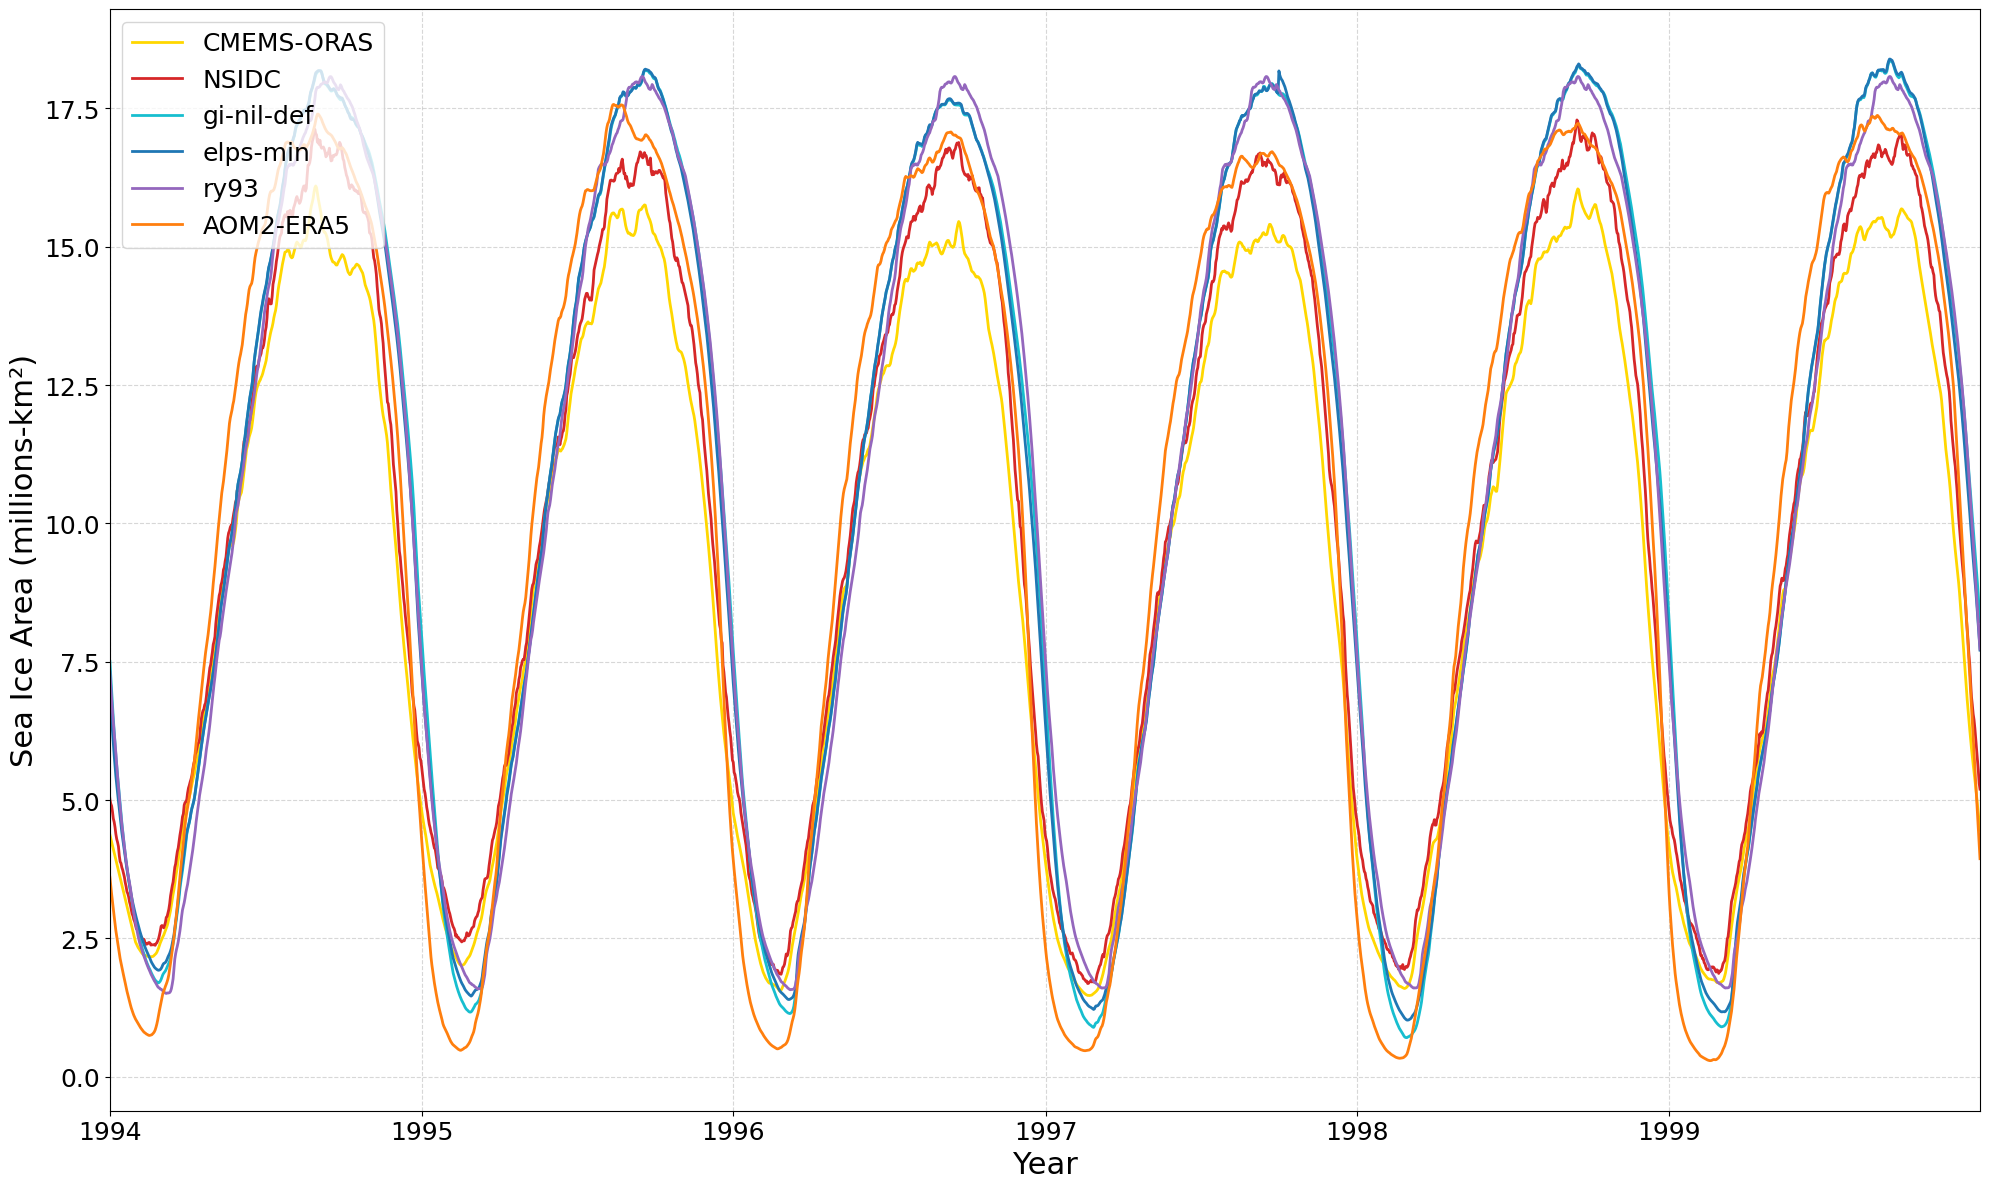

In [13]:
plot_continuous_timeseries_with_optional_climatology(
    PI_stats,
    var="SIA",
    ylabel="Sea Ice Area (millions-km²)",
    save_name="SIA_timeseries_paper1_fig2.png",
    exclude_keys=["ESA_CCI"],
    color_dict=color_dict
)

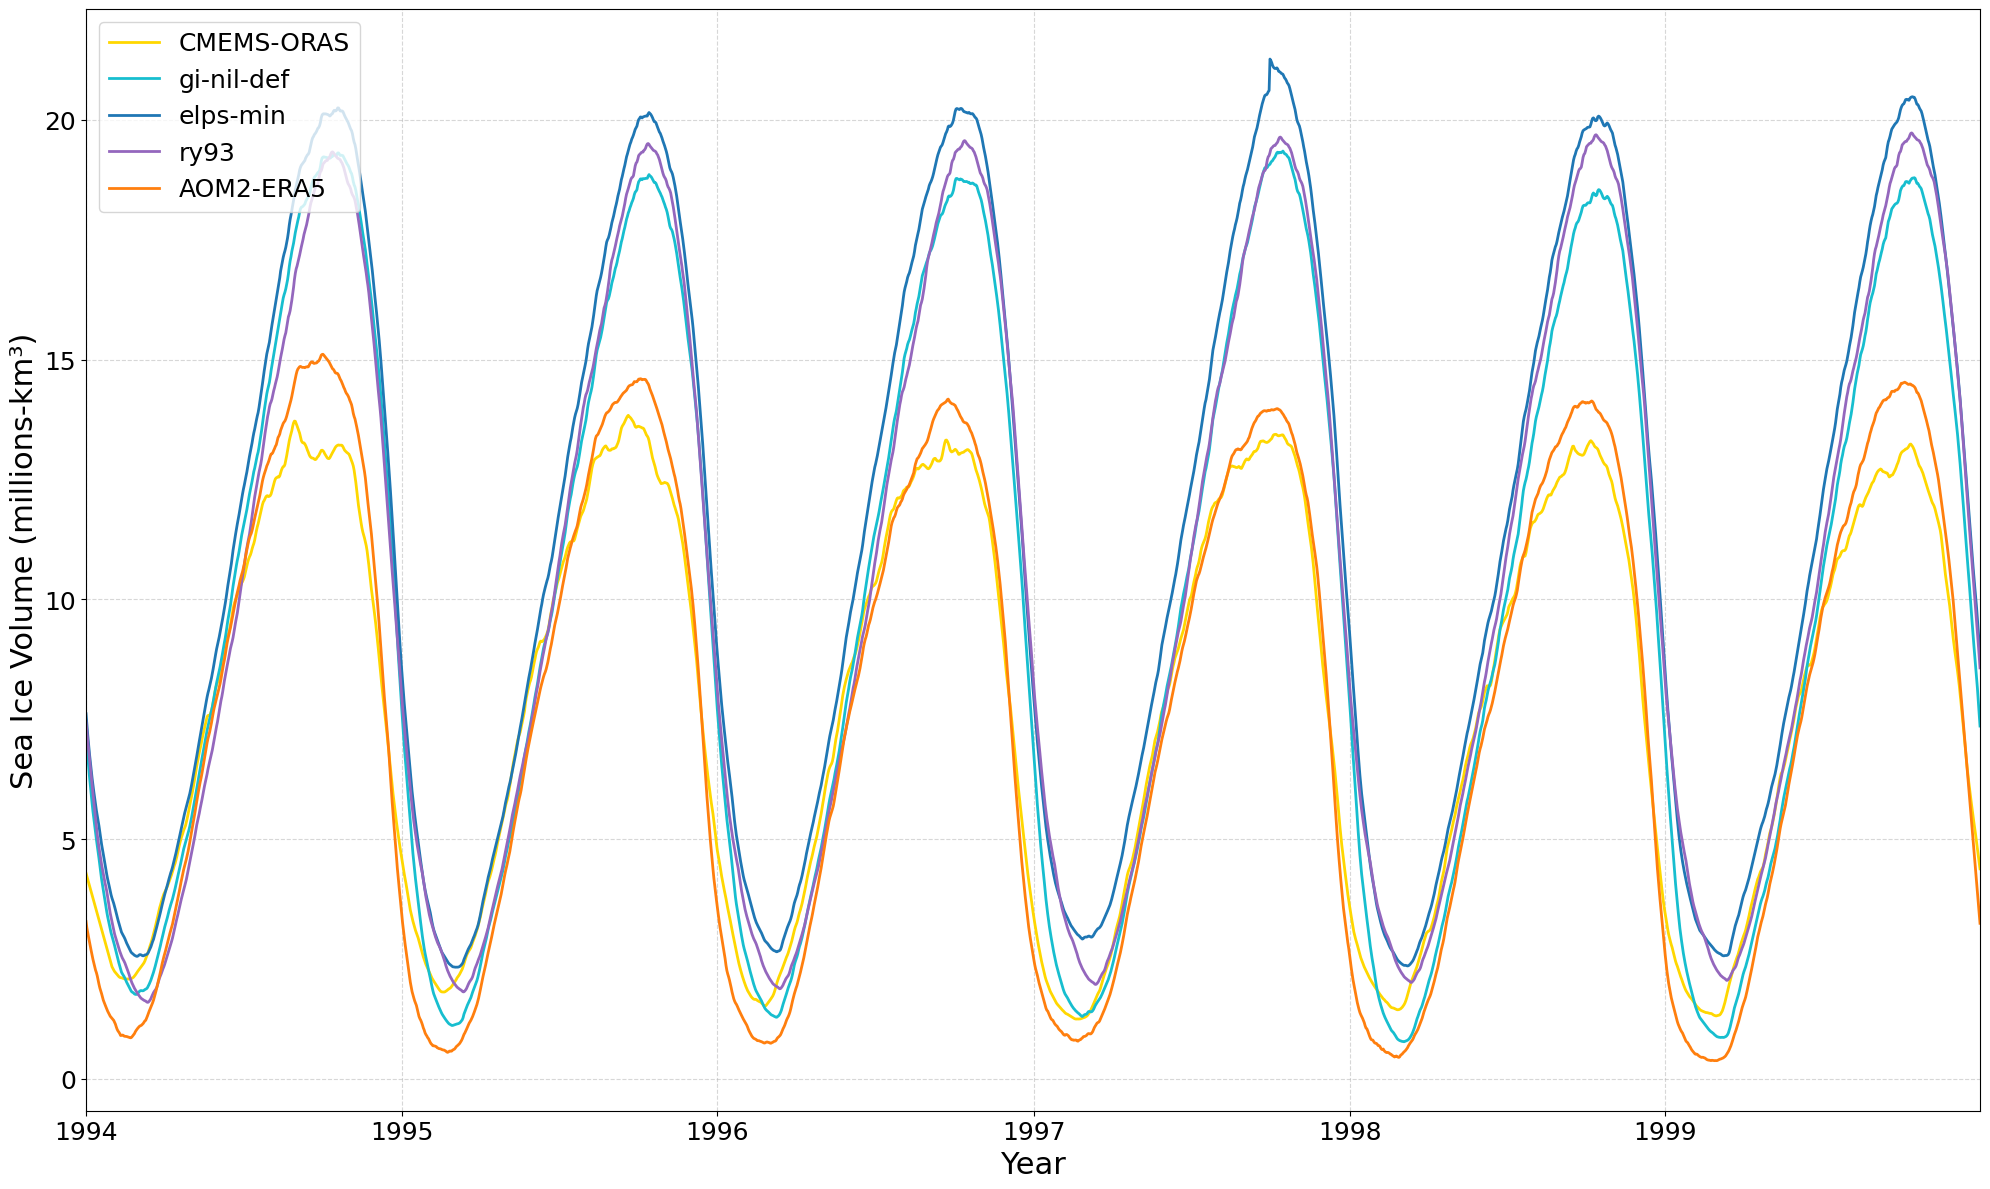

In [14]:
plot_continuous_timeseries_with_optional_climatology(
    PI_stats,
    var="SIV",
    ylabel="Sea Ice Volume (millions-km³)",
    save_name="SIV_timeseries_paper1_fig2.png",
    exclude_keys=["ESA_CCI", "NSIDC"],
    color_dict=color_dict
)


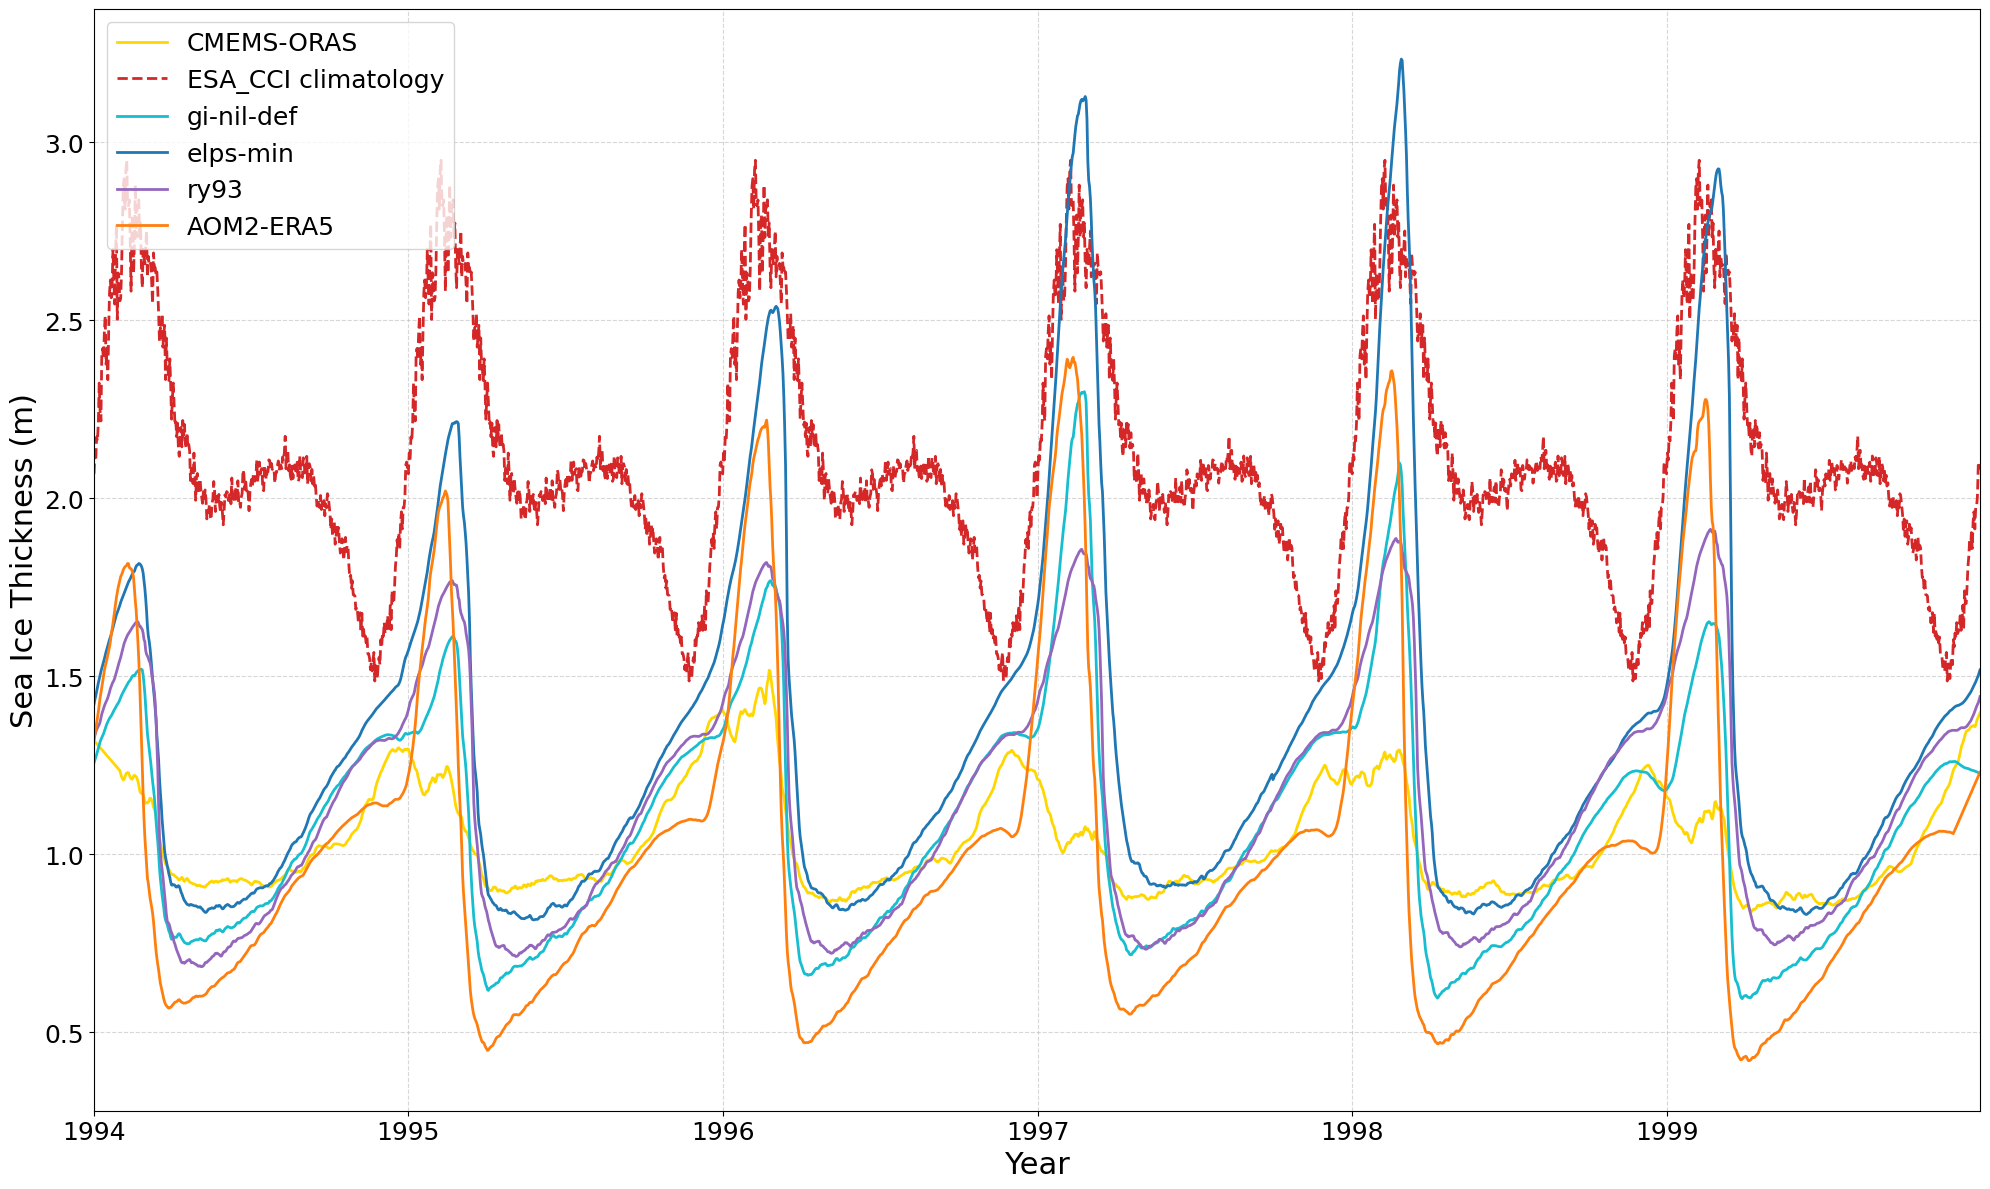

In [15]:
plot_continuous_timeseries_with_optional_climatology(
    PI_stats,
    var="SIT",
    ylabel="Sea Ice Thickness (m)",
    save_name="SIT_timeseries_paper1_fig2.png",
    exclude_keys=["NSIDC"],  # Include ESA_CCI for climatology
    color_dict=color_dict,
    repeat_climatology_key="ESA_CCI",
    model_years=[1994, 1995, 1996, 1997, 1998, 1999]
)


In [29]:
D_search        = Path(Path.home(),"seaice","OSI_SAF","ice_drift_455m",)
F_search        = f"ispd_diffs_pygmt_nn_elps-min_199*.nc"
P_found         = sorted(D_search.rglob(F_search))
ispd_diff       = xr.open_mfdataset(P_found)
ds_jjas         = ispd_diff.sel(time=ispd_diff.time.dt.month.isin([6, 7, 8, 9]))
weekly          = ds_jjas.resample(time="7D").mean()
valid_mask      = np.isfinite(weekly['ispd_obs'])
obs_mean        = weekly['ispd_obs'].where(valid_mask).mean(dim=["ny", "nx"])
elps_min_mean   = weekly['ispd_CICE'].where(valid_mask).mean(dim=["ny", "nx"])
aom2_mean       = weekly['ispd_AOM2'].where(valid_mask).mean(dim=["ny", "nx"])
F_search        = f"ispd_diffs_pygmt_nn_gi-nil-def_199*.nc"
P_found         = sorted(D_search.rglob(F_search))
ispd_diff       = xr.open_mfdataset(P_found)
ds_jjas         = ispd_diff.sel(time=ispd_diff.time.dt.month.isin([6, 7, 8, 9]))
weekly          = ds_jjas.resample(time="7D").mean()
valid_mask      = np.isfinite(weekly['ispd_obs'])
gi_nil_def_mean = weekly['ispd_CICE'].where(valid_mask).mean(dim=["ny", "nx"])
F_search        = f"ispd_diffs_pygmt_nn_ry93_199*.nc"
P_found         = sorted(D_search.rglob(F_search))
ispd_diff       = xr.open_mfdataset(P_found)
ds_jjas         = ispd_diff.sel(time=ispd_diff.time.dt.month.isin([6, 7, 8, 9]))
weekly          = ds_jjas.resample(time="7D").mean()
valid_mask      = np.isfinite(weekly['ispd_obs'])
ry93_mean       = weekly['ispd_CICE'].where(valid_mask).mean(dim=["ny", "nx"])
bias_elps_min   = elps_min_mean - obs_mean
bias_gi_nil_def = gi_nil_def_mean - obs_mean
bias_ry93       = ry93_mean - obs_mean
bias_aom2       = aom2_mean - obs_mean
weekly_bias     = xr.Dataset({"obs_mean"        : obs_mean,
                              "elps_min_mean"   : elps_min_mean,
                              "gi_nil_def_mean" : gi_nil_def_mean,
                              "ry93_mean"       : ry93_mean,
                              "aom2_mean"       : aom2_mean,
                              "bias_elps_min"   : bias_elps_min,
                              "bias_gi_nil_def" : bias_gi_nil_def,
                              "bias_ry93"       : bias_ry93,
                              "bias_aom2"       : bias_aom2})
bias_jjas       = weekly_bias.sel(time=weekly_bias.time.dt.month.isin([6, 7, 8, 9]))
weekofyear      = bias_jjas['time'].dt.isocalendar().week
bias_jjas       = bias_jjas.assign_coords(week=weekofyear)
weekly_clim     = bias_jjas.groupby('week').mean('time')
weekly_std      = bias_jjas.groupby('week').std('time')

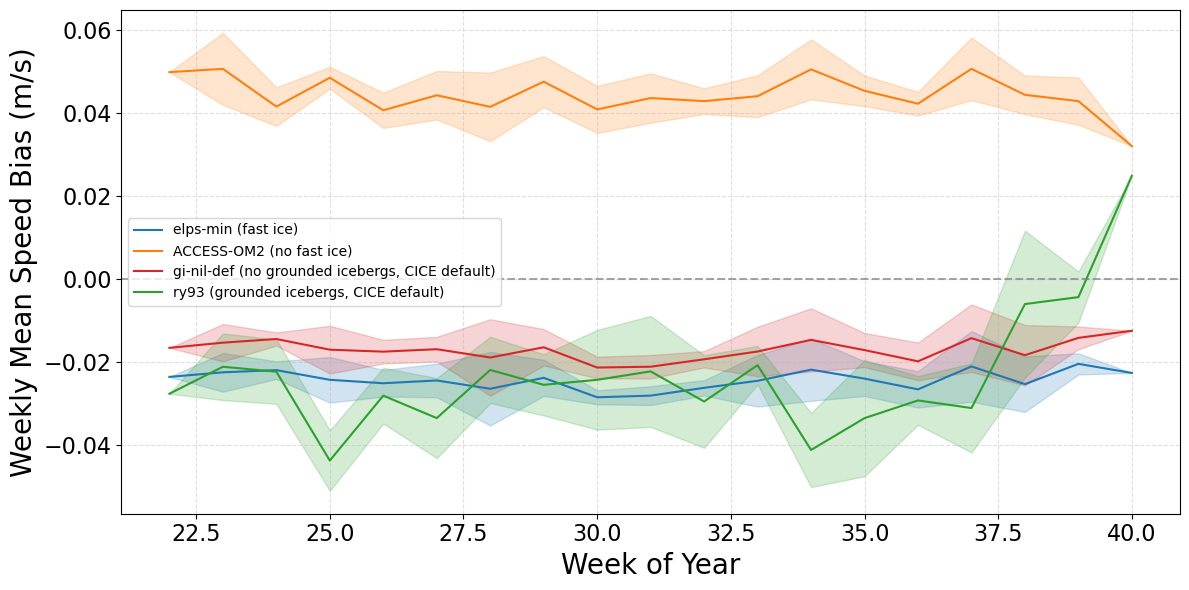

In [35]:
plt.figure(figsize=(12, 6))
colours = {"bias_elps_min"   : "tab:blue",
            "bias_aom2"      : "tab:orange",
            "bias_gi_nil_def": "tab:red",
            "bias_ry93"      : "tab:green"}
labels = {"bias_aom2"      : "ACCESS-OM2 (no fast ice)",
          "bias_elps_min"  : "elps-min (fast ice)",
          "bias_gi_nil_def": "gi-nil-def (no grounded icebergs, CICE default)",
          "bias_ry93"      : "ry93 (grounded icebergs, CICE default)"}
for var in ["bias_elps_min", "bias_aom2", "bias_gi_nil_def", "bias_ry93"]:
    plt.plot(weekly_clim['week'], weekly_clim[var], label=labels[var], color=colours[var] )
    plt.fill_between(weekly_clim['week'],
                     weekly_clim[var] - weekly_std[var],
                     weekly_clim[var] + weekly_std[var],
                     color=colours[var], alpha=0.2 )
plt.axhline(0, ls="--", color="gray", alpha=0.7)
plt.xlabel("Week of Year", fontsize=20)
plt.ylabel("Weekly Mean Speed Bias (m/s)", fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
#plt.title("Climatological Weekly Ice Speed Bias (Jun–Sep)", fontsize=16)
plt.legend()
plt.grid(True, linestyle="--", alpha=0.4)
plt.tight_layout()
P_png = Path(Path.home(),"graphical","AFIM","timeseries","SI_speed_comparison_paper1_fig3.png")
plt.savefig(P_png)
plt.show()

In [ ]:
Image(filename='/g/data/gv90/da1339/GRAPHICAL/AFIM/timeseries/SIV_elps-min_gi-nil_AOM2-ERA5_1994-1999.png')

<a id="spatial-comparisons"></a>
### Spatial Comaprisons 

#### Hemisphere comparisons of sea ice concentration and sea ice thickness

In [ ]:
HTML("""
<video width="1000" controls>
  <source src="https://raw.githubusercontent.com/dpath2o/AFIM/main/docs/figures/elps-min_ispd_BT_Aus_1999-winter.mp4" type="video/mp4">
  Your browser does not support the video tag.
</video>
""")

##### ``AOM2-ERA5``: e = 2, ktens = None, gi-min = None

In [ ]:
HTML("""
<video width="1000" controls>
  <source src="https://raw.githubusercontent.com/dpath2o/AFIM/main/docs/figures/AOM2-ERA5_ispd_BT_Aus_1999-winter.mp4" type="video/mp4">
  Your browser does not support the video tag.
</video>
""")

##### ``gi-nil``: e = 2, ktens = 0.2, gi-min = None

In [ ]:
HTML("""
<video width="1000" controls>
  <source src="https://raw.githubusercontent.com/dpath2o/AFIM/main/docs/figures/gi-nil_ispd_BT_Aus_1999-winter.mp4" type="video/mp4">
  Your browser does not support the video tag.
</video>
""")

### Which is the best method for computing fast ice: binary-day or rolling-mean?

+ create a dictionary of circumpolar fast ice area time series for one simulation (``elps-min``) for a range of different ``binary-day`` and ``rolling-mean`` configurations
+ calculate relevant statistical skills for each configuration against fast ice area observations (``AF2020``)
+ come up with a metric (normalisation-score) for determining the best performing configuration

In [ ]:
FIA_dict   = {}
FIV_dict   = {}
P_dict     = {}
divu_dict  = {}
dvidtt_dict= {}
sim_name   = "elps-min"
dt0_str    = "1994-01-01"
dtN_str    = "1999-12-31"
SI_tools   = SeaIceToolbox(sim_name             = sim_name,
                           dt0_str              = dt0_str,
                           dtN_str              = dtN_str,
                           overwrite_zarr       = True,
                           save_new_figs        = True,
                           show_figs            = True,
                           overwrite_saved_figs = True)
FI_raw, CICE = SI_tools.load_processed_cice( zarr_CICE = True )

#### compute binary-days 
+ this will be binary-days for 7 out of 7, 6 out of 7, 5 out of 7, 8 out of 8, 7 out of 8, 6 out of 8, and so on, until 13 out of 15.
  

In [ ]:
CICE_SO = CICE.isel(nj=SI_tools.hemisphere_dict['nj_slice'])
for win in np.arange(7, 16):  # window sizes: 7 to 15 inclusive
    for cnt in np.arange(win, win - 3, -1):  # max, max-1, max-2 (e.g., 7,6,5)
        key_name = f"elps-min_bin-day_{cnt}of{win}"
        FI_bool               = SI_tools.boolean_fast_ice(FI_raw['FI_mask'], window=win, min_count=cnt)
        aice_bool             = CICE_SO['aice'].where(FI_bool)
        hi_bool               = CICE_SO['hi'].where(FI_bool)
        tarea_bool            = CICE_SO['tarea'].where(FI_bool)
        P_bool                = CICE_SO['strength'].where(FI_bool)
        divu_bool             = CICE_SO['divu'].where(FI_bool)
        dvidtt_bool           = CICE_SO['dvidtt'].where(FI_bool)
        FIA_dict[key_name]    = SI_tools.compute_ice_area(FI_bool, tarea_bool)
        FIV_dict[key_name]    = SI_tools.compute_ice_volume(FI_bool, hi_bool, tarea_bool)
        P_dict[key_name]      = P_bool.sum(dim=('nj','ni'))
        divu_dict[key_name]   = divu_bool.sum(dim=('nj','ni'))
        dvidtt_dict[key_name] = dvidtt_bool.sum(dim=('nj','ni'))
        

In [ ]:
dvidtt_dict['elps-min_bin-day_9of11'].plot()
dvidtt_dict['elps-min_bin-day_11of11'].plot()

In [ ]:
P_dict['elps-min_bin-day_9of11'].plot()
P_dict['elps-min_bin-day_11of11'].plot()

In [ ]:
divu_dict['elps-min_bin-day_9of11'].plot()
divu_dict['elps-min_bin-day_11of11'].plot()

#### compute rolling-mean

+ this will be rolling-means over 7, 10, 13, 16 and 19 day periods
+ then compute FIA on each of those

In [ ]:
for i in np.arange(7,20,3):
    roll_name  = f"elps-min_roll-day_{i:d}"
    CICE_rolls = SI_tools.process_rolling_cice(sim_name         = sim_name,
                                               dt0_str          = dt0_str,
                                               dtN_str          = dtN_str,
                                               mean_period      = i,
                                               ivec_type        = "BT",
                                               write_zarr_group = False)
    FIA_dict[roll_name]    = SI_tools.compute_ice_area(CICE_rolls['FI_mask'], CICE_rolls['tarea'])
    FIV_dict[roll_name]    = SI_tools.compute_ice_volume(CICE_rolls['FI_mask'], CICE_rolls['hi'], CICE_rolls['tarea'])
    P_FI_roll              = CICE_rolls['strength'].where(CICE_rolls['FI_mask'])
    divu_FI_roll           = CICE_rolls['divu'].where(CICE_rolls['FI_mask'])
    dvidtt_FI_roll         = CICE_rolls['dvidtt'].where(CICE_rolls['FI_mask'])
    P_dict[roll_name]      = P_FI_roll.sum(dim=('nj','ni'))
    divu_dict[roll_name]   = divu_FI_roll.sum(dim=('nj','ni'))
    dvidtt_dict[roll_name] = dvidtt_FI_roll.sum(dim=('nj','ni'))

#### compute statistics for each configuration

In [ ]:
P_FIA_comparison = Path(SI_tools.D_sim,"FIA_time-series_multi-bin-days_multi-roll-days.zarr")

ts_ds     = SI_tools.dict_to_ds(FIA_dict)
ts_ds_cnk = ts_ds.chunk({'time':30})
ts_ds_cnk.to_zarr(Path(SI_tools.D_sim,"FIA_time-series_multi-bin-days_multi-roll-days.zarr"), mode="w")
ts_ds     = SI_tools.dict_to_ds(FIV_dict)
ts_ds_cnk = ts_ds.chunk({'time':30})
ts_ds_cnk.to_zarr(Path(SI_tools.D_sim,"FIV_time-series_multi-bin-days_multi-roll-days.zarr"), mode="w")
ts_ds     = SI_tools.dict_to_ds(P_dict)
ts_ds_cnk = ts_ds.chunk({'time':30})
ts_ds_cnk.to_zarr(Path(SI_tools.D_sim,"FI-strength_time-series_multi-bin-days_multi-roll-days.zarr"), mode="w")
ts_ds     = SI_tools.dict_to_ds(divu_dict)
ts_ds_cnk = ts_ds.chunk({'time':30})
ts_ds_cnk.to_zarr(Path(SI_tools.D_sim,"FI-strain-rate_time-series_multi-bin-days_multi-roll-days.zarr"), mode="w")
ts_ds     = SI_tools.dict_to_ds(dvidtt_dict)
ts_ds_cnk = ts_ds.chunk({'time':30})
ts_ds_cnk.to_zarr(Path(SI_tools.D_sim,"FI-thermo-vol-tend_time-series_multi-bin-days_multi-roll-days.zarr"), mode="w")
AF_clim = SI_tools.load_AF2020_FIA_summary(start="1994-01-01", end="1999-12-31")
obs_fia = SI_tools.AF2020_clim_to_model_time( ts_dict['elps-min_bin-day_7of7'] , AF_clim["FIA_clim"].sel(region="circumpolar"))
ts_dict_stats = {}
for key in FIA_dict.keys():
    print(key)
    FIA_dict_stats[key] = SI_tools.compute_statistics( FIA_dict[key], obs_fia )

#### compute a normalised-score to rank the configurations

In [ ]:
df['Abs_Bias'] = np.abs(df['Bias'])
df['SD_Diff']  = np.abs(df['SD_Model'] - df['SD_Obs'])
df['score']    = (df['Abs_Bias'] / df['Abs_Bias'].max() +
                   df['RMSE']     / df['RMSE'].max() +
                   df['MAE']      / df['MAE'].max() +
                   df['SD_Diff']  / df['SD_Diff'].max() +
                   (1 - df['Corr']) / (1 - df['Corr'].min()))
best_method    = df['score'].idxmin()
df_sorted      = df.sort_values(by='score')
print("Best-aligned method with observed FIA:", best_method)
df_sorted[['Bias', 'RMSE', 'MAE', 'Corr', 'SD_Model', 'SD_Obs']].head(5)

#### plot the Taylor Diagram

In [ ]:
from taylor import TaylorDiagram
# Prepare data for the Taylor diagram
scores = df_sorted[['Corr', 'SD_Obs', 'SD_Model', 'RMSE', 'MAE', 'Bias']].values
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, polar=True)
# Taylor Diagram requires the standard deviation, correlation, and RMS error
# Correlation values go from -1 to 1, so we compute the points to plot
correlation = scores[:, 0]  # Correlation
sd_obs = scores[:, 1]       # Standard deviation of observations
sd_model = scores[:, 2]     # Standard deviation of model
rmse = scores[:, 3]         # Root Mean Square Error
mae = scores[:, 4]          # Mean Absolute Error
bias = scores[:, 5]         # Bias
# Plot the points for each method
for i, method in enumerate(df_sorted.index):
    ax.plot(np.arccos(correlation[i]), np.sqrt(sd_model[i]**2 + rmse[i]**2), marker='o', label=method)
# Highlight the best method
ax.plot(np.arccos(correlation[df_sorted.index.get_loc(best_method)]), 
        np.sqrt(sd_model[df_sorted.index.get_loc(best_method)]**2 + rmse[df_sorted.index.get_loc(best_method)]**2), 
        marker='x', color='red', label=f"Best Method: {best_method}")
# Labels and title
ax.set_title("Taylor Plot for Model Comparison")
ax.set_xlabel("Correlation")
ax.set_ylabel("Standard Deviation")
# Add a legend
ax.legend()
# Display the plot
plt.show()


In [ ]:
sim_name   = "elps-min"
SI_tools   = SeaIceToolbox( sim_name = sim_name )
AF2020_CSV = SI_tools.load_AF2020_FIA_summary()
obs_FIA    = AF2020_CSV['FIA_clim_repeat'].sel(region='circumpolar')
FIA_sim    = xr.open_zarr(Path(Path.home(),"AFIM_archive","elps-min","FIA_time-series_multi-bin-days_multi-roll-days.zarr"))
dt         = pd.to_datetime(FIA_sim["time"].values)
valid_dt   = dt.year > 1993 
FIA_sim    = FIA_sim.sel(time=valid_dt)
print(FIA_sim.time.values)

In [ ]:
FIA_dict = {"AF2020"                  : obs_FIA,
            "elps-min_bin-day_13of15"  : FIA_sim['elps-min_bin-day_13of15'],
            "elps-min_bin-day_14of15" : FIA_sim['elps-min_bin-day_14of15'],
            "elps-min_bin-day_15of15" : FIA_sim['elps-min_bin-day_15of15'],
            "elps-min_roll-day_16"    : FIA_sim['elps-min_roll-day_16']}
SI_tools.plot_timeseries_matplotlib(FIA_dict,
                        ylabel    = "Fast Ice Area (1000-km²)",
                        P_png     = Path(SI_tools.D_graph,"timeseries","FIA_elps-min_bin-day_comparison_15day.png"))
SI_tools.plot_monthly_ice_metric_by_year(FIA_dict,
                                        ice_type         = "FIA",
                                        figsize          = (18, 10),
                                        P_png            = Path(SI_tools.D_graph,sim_name,"FIA_elps-min_bin-day_comparison_15day_by_doy.png"),
                                        plot_annotations = False)

In [ ]:
Image(filename="/g/data/gv90/da1339/GRAPHICAL/AFIM/timeseries/FIA_elps-min_bin-day_comparison_7day.png")

In [ ]:
Image(filename="/g/data/gv90/da1339/GRAPHICAL/AFIM/timeseries/FIA_elps-min_bin-day_comparison_11day.png")

In [ ]:
Image(filename="/g/data/gv90/da1339/GRAPHICAL/AFIM/timeseries/FIA_elps-min_bin-day_comparison_15day.png")

In [ ]:
#Image(filename="/g/data/gv90/da1339/GRAPHICAL/AFIM/elps-min/FIA_elps-min_and_AF2020_2000-2018.png")
Image(filename="/g/data/gv90/da1339/GRAPHICAL/AFIM/elps-min/FIA_elps-min_bin-day_comparison_7day_by_doy.png")

In [ ]:
Image(filename="/g/data/gv90/da1339/GRAPHICAL/AFIM/elps-min/FIA_elps-min_bin-day_comparison_11day_by_doy.png")

In [ ]:
Image(filename="/g/data/gv90/da1339/GRAPHICAL/AFIM/elps-min/FIA_elps-min_bin-day_comparison_15day_by_doy.png")

### Can we realistically simulate the:

1.  fast ice area min

2.  fast ice area max

3.  seasonality

4.  thickness

5.  inter-annual variability

6.  all the while maintaining [pack ice (see above)](#spatial-comparisons)

### Fast ice comparison for simulation ``elps-min`` (and maybe ``elps-mid``)

+ ($e=1.2$, $k_t = 0.2$, $GI_{thin}=0.25$) versus [AF2020 FI db](https://tc.copernicus.org/articles/15/5061/2021/)
+ these results are based on 2000 to 2018 direct comparison
  

#### ``elps-min`` compute FIA and plot both continuous time series and climatology (groupby DOY)

In [ ]:
sim_name = "elps-min"
dt0_str  = "2000-01-01"
dtN_str  = "2018-12-31"
years    = range(2000, 2019)
SI_tools = SeaIceToolbox(sim_name            = sim_name,
                        client               = None,
                        dt0_str              = dt0_str,
                        dtN_str              = dtN_str,
                        ice_speed_threshold  = 5e-4,
                        ice_speed_type       = "ispd_BT",
                        ice_type             = "FI_BT",
                        overwrite_zarr       = False,
                        save_new_figs        = True,
                        show_figs            = False,
                        overwrite_saved_figs = True)
P_FI_diff            = Path(SI_tools.D_sim,f"FI-diff_obs-elps-min_{dt0_str[:3]}-{dtN_str[:3]}.nc")
FI_raw, CICE         = SI_tools.load_processed_cice( zarr_CICE = True )
CICE_SO              = CICE.isel(nj=SI_tools.hemisphere_dict['nj_slice'])

In [ ]:
FI_bool              = SI_tools.boolean_fast_ice( FI_raw['FI_mask'])
aice_bool            = CICE_SO['aice'].where(FI_bool)
tarea_bool           = CICE_SO['tarea'].where(FI_bool)
D_obs                = Path(SI_tools.AF_FI_dict['D_AF2020_db_org'])
P_orgs               = sorted(D_obs.glob("FastIce_70_*.nc"))
FI_obs               = xr.open_mfdataset(P_orgs, engine='netcdf4', combine='by_coords')
FI_obs               = FI_obs.chunk({'time':1})
def threshold_mask(block):
    return xr.where(block >= 4, 1, 0)
FI_obs_mask              = FI_obs['Fast_Ice_Time_series'].map_blocks(threshold_mask)
FI_obs_ts                = FI_obs_mask.astype(int)
FI_sim_coar              = SI_tools.coarsen_and_align_simulated_FI_to_observed_FI(FI_bool, FI_obs_ts)
aice_coar                = SI_tools.coarsen_and_align_simulated_FI_to_observed_FI(aice_bool, FI_obs_ts)
tarea_coar               = SI_tools.coarsen_and_align_simulated_FI_to_observed_FI(tarea_bool, FI_obs_ts)
FIA_obs                  = SI_tools.compute_ice_area( FI_obs_ts, FI_obs['area'], ice_area_scale=1e3, spatial_dim_names=('Y','X') , add_grounded_iceberg_area=False)

In [ ]:
FIA_sim                  = SI_tools.compute_ice_area( aice_coar, tarea_coar )
FIA_obs_algn, FIA_sim_algn = xr.align(FIA_obs, FIA_sim, join="inner")
FIA_dict                   = {'elps-min' : FIA_sim_algn, 'AF2020' : FIA_obs_algn }

##### graphic results

##### compute spatial difference for each time-step (432 in total) and plot for 8 Antarctic regions, show animation

+ [create_FI_diff_plots.py](https://github.com/dpath2o/AFIM/blob/main/scripts/plotting/create_FI_diff_plots.py) is responsible for creating these figures

In [ ]:
FIP_sim = SI_tools.compute_variable_aggregate( FI_bool )
FIP_obs - SI_tools.compute_variable_aggregate( FI_obs_ts )


#### graphic results

In [ ]:
sim_name = "elps-min"
for region in SI_tools.Ant_8sectors.keys():
    SI_tools = SeaIceToolbox(sim_name=sim_name)
    D_png = Path(SI_tools.D_graph, sim_name, region, "FI_diff")
    D_ani = Path(SI_tools.D_graph, "animations", sim_name, "FI_diff")
    F_ani = f"{sim_name}_FI-diff_{region}_2000-2018.mp4"
    P_ani = Path(D_ani,F_ani)
    P_mp4 = Path.home() / "AFIM" / "src" / "AFIM" / "docs" / "figures" / F_ani
    D_ani.mkdir(parents=True, exist_ok=True)
    frames = sorted([f for f in os.listdir(D_png) if f.endswith(".png")])
    os.system(f"rm {SI_tools.D_tmp}/frame_*.png")
    for i, f in enumerate(frames):
        src = D_png / f
        dst = Path(SI_tools.D_tmp) / f"frame_{i:04d}.png"
        if not dst.exists():
            os.symlink(src, dst)
    os.system(f"ffmpeg -y -r 2 -i {SI_tools.D_tmp}/frame_%04d.png -vf \"scale=iw:ih+mod(2-ih\\,2)\" -c:v libx264 -pix_fmt yuv420p {P_ani}")
    os.system(f"cp {P_ani} {P_mp4}")
    

In [ ]:
HTML("""
<video width="1000" controls>
  <source src="https://raw.githubusercontent.com/dpath2o/AFIM/main/docs/figures/elps-min_FI-diff_AS_2000-2018.mp4" type="video/mp4">
  Your browser does not support the video tag.
</video>
""")

In [ ]:
HTML("""
<video width="1000" controls>
  <source src="https://raw.githubusercontent.com/dpath2o/AFIM/main/docs/figures/elps-min_FI-diff_Aus_2000-2018.mp4" type="video/mp4">
  Your browser does not support the video tag.
</video>
""")

In [ ]:
HTML("""
<video width="1000" controls>
  <source src="https://raw.githubusercontent.com/dpath2o/AFIM/main/docs/figures/elps-min_FI-diff_BS_2000-2018.mp4" type="video/mp4">
  Your browser does not support the video tag.
</video>
""")

In [ ]:
HTML("""
<video width="1000" controls>
  <source src="https://raw.githubusercontent.com/dpath2o/AFIM/main/docs/figures/elps-min_FI-diff_DML_2000-2018.mp4" type="video/mp4">
  Your browser does not support the video tag.
</video>
""")

In [ ]:
HTML("""
<video width="1000" controls>
  <source src="https://raw.githubusercontent.com/dpath2o/AFIM/main/docs/figures/elps-min_FI-diff_EIO_2000-2018.mp4" type="video/mp4">
  Your browser does not support the video tag.
</video>
""")

In [ ]:
HTML("""
<video width="1000" controls>
  <source src="https://raw.githubusercontent.com/dpath2o/AFIM/main/docs/figures/elps-min_FI-diff_VOL_2000-2018.mp4" type="video/mp4">
  Your browser does not support the video tag.
</video>
""")

In [ ]:
HTML("""
<video width="1000" controls>
  <source src="https://raw.githubusercontent.com/dpath2o/AFIM/main/docs/figures/elps-min_FI-diff_WIO_2000-2018.mp4" type="video/mp4">
  Your browser does not support the video tag.
</video>
""")

In [ ]:
HTML("""
<video width="1000" controls>
  <source src="https://raw.githubusercontent.com/dpath2o/AFIM/main/docs/figures/elps-min_FI-diff_WS_2000-2018.mp4" type="video/mp4">
  Your browser does not support the video tag.
</video>
""")

### Seasonality and inter-annual variability

In [ ]:
sim_name            = "elps-min"
SI_tools            = SeaIceToolbox(sim_name = sim_name)
FI_mets             = xr.open_dataset(Path(SI_tools.D_zarr,"ispd_thresh_5.0e-4","metrics","FI_BT_bool_mets.zarr"))
FIA_obs             = SI_tools.load_AF2020_FI_area_timeseries()
FIA_dict            = {}
FIA_dict['FIA_obs'] = FIA_obs
FIA_dict['FIA_sim'] = FI_mets['FIA']
FIA_obs_df          = FIA_dict['FIA_obs']  # pandas DataFrame
FIA_sim             = FIA_dict['FIA_sim']  # xarray DataArray with .time and daily frequency
obs_daily_list      = []
for year in FIA_obs_df['Year'].unique():
    subset     = FIA_obs_df[FIA_obs_df['Year'] == year]
    doys       = ((subset['DOY_start'] + subset['DOY_end']) // 2).values
    dates      = pd.to_datetime(f"{year}-01-01") + pd.to_timedelta(doys - 1, unit='D')
    ts         = pd.Series(subset['circumpolar'].values, index=dates)
    full_range = pd.date_range(start=f"{year}-01-01", end=f"{year}-12-31", freq='D')
    ts_daily   = ts.reindex(full_range).interpolate("linear").ffill().bfill()
    obs_daily_list.append(ts_daily)
FIA_obs_daily   = pd.concat(obs_daily_list).sort_index()
sim_dates       = pd.to_datetime(FIA_sim['time'].values)
FIA_obs_aligned = FIA_obs_daily.reindex(sim_dates).interpolate("linear").ffill().bfill()
FIA_obs_aligned = FIA_obs_aligned/1e3
FIA_sim_smooth  = FIA_sim.rolling(time=15, center=True).mean()
FIA_diff_norm   = (FIA_obs_aligned - FIA_sim_smooth) / FIA_obs_aligned 
fig, ax1        = plt.subplots(figsize=(20, 12))
ax1.plot(sim_dates, FIA_sim_smooth, label="model (CICE6-standalone)", color='blue', linewidth=1)
ax1.plot(sim_dates, FIA_obs_aligned, label="observed", color='black', linestyle='--')
ax1.tick_params(size=14, axis='y', labelcolor='black')
ax2 = ax1.twinx()
ax2.plot(sim_dates, FIA_diff_norm, label="(Obs - Sim) / Obs [%]", color='gray', alpha=0.5)
ax2.tick_params(size=14, axis='y', labelcolor='gray')
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')
plt.title("Circumpolar Antarctic Fast Ice Area 2000-2018: Observations vs Model", fontsize=20)
ax1.set_ylabel("Area (1000 km²)", fontsize=18)
ax2.set_ylabel("Relative Difference (%)", color='gray', fontsize=18)
ax1.set_xlabel("Date", fontsize=18)
ax1.set_ylim([100, 800])
ax2.set_ylim([-1,1])
ax1.set_xlim(pd.Timestamp("2000-03-01"), pd.Timestamp("2018-03-01"))
plt.tight_layout()
plt.show()
results = []
for year in range(2000, 2019):
    t0 = pd.Timestamp(f"{year}-01-01")
    tN = pd.Timestamp(f"{year}-12-31")
    sim_year = FIA_sim_smooth.sel(time=slice(t0, tN)).to_series()
    obs_year = FIA_obs_aligned.loc[t0:tN]
    sim_year = sim_year.dropna()
    obs_year = obs_year.dropna()
    if len(sim_year) == 0 or len(obs_year) == 0:
        continue
    sim_min_val    = sim_year.min()
    sim_min_day    = sim_year.idxmin()
    sim_max_val    = sim_year.max()
    sim_max_day    = sim_year.idxmax()
    obs_min_val    = obs_year.min()
    obs_min_day    = obs_year.idxmin()
    obs_max_val    = obs_year.max()
    obs_max_day    = obs_year.idxmax()
    delta_min_mag  = sim_min_val - obs_min_val
    delta_min_time = (sim_min_day - obs_min_day).days
    delta_max_mag  = sim_max_val - obs_max_val
    delta_max_time = (sim_max_day - obs_max_day).days
    results.append({"year"     : year,
                    "sim_min"  : sim_min_val,
                    "obs_min"  : obs_min_val,
                    "Δmin_mag" : delta_min_mag,
                    "Δmin_day" : delta_min_time,
                    "sim_max"  : sim_max_val,
                    "obs_max"  : obs_max_val,
                    "Δmax_mag" : delta_max_mag,
                    "Δmax_day" : delta_max_time})
comparison_df = pd.DataFrame(results)
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(comparison_df['year'] - 0.2, comparison_df['Δmin_mag'], label='Δmin_mag (Obs - Sim)', color='steelblue')
ax.plot(comparison_df['year'] + 0.2, comparison_df['Δmax_mag'], label='Δmax_mag (Obs - Sim)', color='coral')
ax.set_xlabel("Year")
ax.set_ylabel("Δ Magnitude (km²)")
ax.set_title("Observed - Model Min/Max FIA Magnitude per Year")
ax.legend()
ax.grid(True, axis='y')
plt.tight_layout()
plt.show()
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(comparison_df['year'] - 0.2, comparison_df['Δmin_day'], label='Δmin_day (days)', color='slategray')
ax.plot(comparison_df['year'] + 0.2, comparison_df['Δmax_day'], label='Δmax_day (days)', color='darkorange')
ax.set_xlabel("Year")
ax.set_ylabel("Δ Timing (days)")
ax.set_title("Observed - Model Timing of Min/Max FIA per Year")
ax.axhline(0, color='black', linestyle='--', linewidth=0.8)
ax.legend()
ax.grid(True, axis='y')
plt.tight_layout()
plt.show()


In [ ]:
Image("/g/data/gv90/da1339/GRAPHICAL/AFIM/elps-min/AS/FIP_delta/2000-2018_elps-min_AS_FIP_delta.png")

In [ ]:
Image("/g/data/gv90/da1339/GRAPHICAL/AFIM/elps-min/Aus/FIP_delta/2000-2018_elps-min_Aus_FIP_delta.png")

In [ ]:
Image("/g/data/gv90/da1339/GRAPHICAL/AFIM/elps-min/BS/FIP_delta/2000-2018_elps-min_BS_FIP_delta.png")

In [ ]:
Image("/g/data/gv90/da1339/GRAPHICAL/AFIM/elps-min/DML/FIP_delta/2000-2018_elps-min_DML_FIP_delta.png")

In [ ]:
Image("/g/data/gv90/da1339/GRAPHICAL/AFIM/elps-min/EIO/FIP_delta/2000-2018_elps-min_EIO_FIP_delta.png")

In [ ]:
Image("/g/data/gv90/da1339/GRAPHICAL/AFIM/elps-min/VOL/FIP_delta/2000-2018_elps-min_VOL_FIP_delta.png")

In [ ]:
Image("/g/data/gv90/da1339/GRAPHICAL/AFIM/elps-min/WIO/FIP_delta/2000-2018_elps-min_WIO_FIP_delta.png")

In [ ]:
Image("/g/data/gv90/da1339/GRAPHICAL/AFIM/elps-min/WS/FIP_delta/2000-2018_elps-min_WS_FIP_delta.png")

## Fast ice area and volume comparisons for each tested parameter
1.  What is the optimal concentration of grounded icebergs that should be used?
2.  Is there a relationship between sea ice speed threshold and fast ice area?

In [ ]:
sim_name = "elps-min"
dt0_str  = "1994-01-01"
dtN_str  = "1999-12-31"
SI_tools = SeaIceToolbox(sim_name            = sim_name,
                        client               = None,
                        dt0_str              = dt0_str,
                        dtN_str              = dtN_str,
                        ice_speed_threshold  = 5e-4,
                        ice_speed_type       = "ispd_BT",
                        ice_type             = "FI_BT",
                        overwrite_zarr       = False,
                        save_new_figs        = True,
                        show_figs            = False,
                        overwrite_saved_figs = True)

In [ ]:
FIA_dict           = {}
AF2020_CSV         = SI_tools.load_AF2020_FIA_summary( start=dt0_str, end=dtN_str )
FIA_dict["AF2020"] = AF2020_CSV['FIA_clim_repeat'].sel(region='circumpolar')
FIV_dict           = {} 

for sim_name in ["ndte-min", "ndte-max", "ndte-max-re-off", "elps-min", "gi-nil-def"]:
    mets = xr.open_zarr(f"/g/data/gv90/da1339/afim_output/{sim_name}/zarr/ispd_thresh_5.0e-4/metrics/FI_BT_bool_mets.zarr")
    
    # Filter FIA and FIV related variables
    fia_vars = {var: mets[var] for var in mets.data_vars if var.startswith("FIA")}
    fiv_vars = {var: mets[var] for var in mets.data_vars if var.startswith("FIV")}
    
    # Store in dictionary by sim_name
    FIA_dict[sim_name] = fia_vars
    FIV_dict[sim_name] = fiv_vars


In [ ]:
SI_tools.plot_timeseries(FIA_dict,
                         primary_key = "FIA",
                         ylabel    = "Fast Ice Area (1000-km^2)",
                         fig_width  = "50c",
                         fig_height = "15c",
                         legend_pos = "JBL+jBL+o0.2c+w50c",
                         P_png     = Path(SI_tools.D_graph,"timeseries","FIA_ndte-comparison_1994-1999.png"),
                         show_fig  = False)
SI_tools.plot_timeseries_groupby_doy(FIA_dict,
                                     primary_key = "FIA",
                                     fig_width  = "25c",
                                     fig_height = "20c",
                                     legend_pos = "JTL+jTL+o0.2c",
                                     P_png      = Path(SI_tools.D_graph,"timeseries","FIA_ndte-comparison_DOY_1994-1999.png"),
                                     show_fig   = True)

In [ ]:
Image(filename="/g/data/gv90/da1339/GRAPHICAL/AFIM/timeseries/FIA_ndte-comparison_1994-1999.png")

In [ ]:
FIA_dict


In [ ]:
SI_tools.plot_timeseries_matplotlib(FIV_dict,
                                    ylabel    = "Fast Ice Volume (1e6-km^3)",
                                    ylim      = [.25,2.25],
                                    P_png     = Path(SI_tools.D_graph,"timeseries","FIV_ndte-comparison_1994-1999.png"),
                                    keys2plot = None,
                                    show_fig  = True)
SI_tools.plot_monthly_ice_metric_by_year(FIV_dict,
                                        ice_type         = "FIV",
                                        roll_days        = 0,
                                         ylim            = [.25,2.25],
                                        figsize          = (18, 10),
                                        P_png            = Path(SI_tools.D_graph,sim_name,"FIV_ndte-comparison_1994-1999.png"),
                                        plot_annotations = False)

### Comparison of internal stress parameter $C^\ast$ 

(``Cstar-min`` : $C^\ast = 10$ and ``Cstar-max`` : $C^\ast = 30$), other parameters $e=2.0$, $k_t=0.2$, $GI-thin=0.25$

In [ ]:
Image("/g/data/gv90/da1339/GRAPHICAL/AFIM/timeseries/FIA_Cstar_comparison.png")

### Comparison of internal stress parameter $P^\ast$

(``Pstar-min`` : $P^\ast = 5\times10^4$ and ``Pstar-max`` : $P^\ast = 1\times10^4$), other parameters $e=2.0$, $k_t=0.2$, $GI-thin=0.25$

In [ ]:
Image("/g/data/gv90/da1339/GRAPHICAL/AFIM/timeseries/FIA_Pstar_comparison.png")

### Comparison of tensile stress $k_t$

(``ktens-nil`` : $k_t = 0$, ``ktens-min`` : $k_t = 0.1$, ``ktens-max`` : $k_t = 0.3$, ``ktens-ext`` : $k_t = 0.6$), other parameters $e=2.0$, $GI-thin=0.25$

In [ ]:
Image("/g/data/gv90/da1339/GRAPHICAL/AFIM/timeseries/FIA_ktens_comparison.png")

### Comparison of ellipse eccentricity

(``elps-max`` : $e = 2.5$, ``elps-mid`` : $e = 1.6$, ``elps-min`` : $e = 1.2$, ``elps-ext`` : $e = 0.8$), other parameters $k_t=0.2$, $GI-thin=0.25$

In [ ]:
Image("/g/data/gv90/da1339/GRAPHICAL/AFIM/timeseries/FIA_elps_comparison.png")

### Comparison of grounded iceberg concentrations

(``gi-nil`` : $GI_{thin} = 0$, ``gi-min`` : $GI_{thin} = 0.15$, ``gi-mid`` : $GI_{thin} = 0.25$, ``gi-max`` : $GI_{thin} = 0.35$), other parameters $e=2.0$, $k_t=0.2$

In [ ]:
Image("/g/data/gv90/da1339/GRAPHICAL/AFIM/timeseries/FIA_GI-con_comparison.png")

### Comparison of grounded iceberg ensembles runs

(``elps-min-gi1``, ``elps-min-gi2`` ``elps-min-gi3``), other parameters $e=2.0$, $k_t=0.2$ $GI_{thin}=0.25$

In [ ]:
Image("/g/data/gv90/da1339/GRAPHICAL/AFIM/timeseries/FIA_GI-var_comparison.png")

### Comparison of sub-cycle iterations

(``ndte``) (``gi-mid`` : ``ndte``$=240$, ``ndte-min`` : ``ndte`` $=120$, ``ndte-max`` : ``ndte``$=720$), other parameters $e=2.0$, $k_t=0.2$, $GI-thin=0.25$

In [ ]:
Image("/g/data/gv90/da1339/GRAPHICAL/AFIM/timeseries/FIA_ndte_comparison.png")

### Effect of turning off ``revised-EVP``

In [ ]:
Image("/g/data/gv90/da1339/GRAPHICAL/AFIM/timeseries/FIA_re-EVP_comparison.png")

### The of turning on Rothrock internal ice strength formulation (``kstrength``$=1$) and then tuning Rothrock ice strength parameter $Cf$.

``Roth-cf-def`` $Cf=17$, ``Roth-cf-min`` $Cf=10$, and ``Roth-cf-max`` $Cf=24$

In [ ]:
Image("/g/data/gv90/da1339/GRAPHICAL/AFIM/timeseries/FIA_Roth_comparison.png")

## Do the thermodynamics and mechanical dynamics continue to \`\`behave\'\' when CICE is *heavily tuned* for fast ice?

(limited due to standalone configuration)

## Is there a relationship between sea ice speed threshold and fast ice area?

In [ ]:
log_scale = False  # Set to False for linear
if log_scale:
    F_name = "ispd-thresh_vs_FIA-min-max_logscale.png"
else:
    F_name = "ispd-thresh_vs_FIA-min-max.png"
sim_name = "elps-min"
base_dir = f"/g/data/gv90/da1339/afim_output/{sim_name}/zarr"
threshold_dirs = sorted([d for d in os.listdir(base_dir) if d.startswith("ispd_thresh_")])
ispd_vals = [float(d.split('_')[2]) for d in threshold_dirs]
FIA_stats = {"FI_BT_bool": {},
             "FI_BT_roll": {}}
def get_fia_stats(path):
    try:
        ds = xr.open_zarr(path)
        fia = ds["FIA"].sel(time=slice("1994-01-01", "1999-12-31"))
        # Group by year and compute annual min/max
        fia_by_year = fia.groupby("time.year")
        min_by_year = fia_by_year.min(dim="time")
        max_by_year = fia_by_year.max(dim="time")
        # Compute the mean of annual min/max
        return float(min_by_year.mean().values), float(max_by_year.mean().values)
    except Exception as e:
        print(f"Error with {path}: {e}")
        return np.nan, np.nan
# Define a function to interpolate where the method curve crosses the observed value
def interpolate_x(x, y, y_obs):
    x = np.array(x)
    y = np.array(y)
    for i in range(len(x) - 1):
        if np.isnan(y[i]) or np.isnan(y[i + 1]):
            continue
        if (y[i] - y_obs) * (y[i + 1] - y_obs) < 0:
            # Linear interpolation in log or linear space depending on axis setting
            return x[i] + (y_obs - y[i]) * (x[i + 1] - x[i]) / (y[i + 1] - y[i])
    return None

for dir_name in threshold_dirs:
    threshold = float(dir_name.split("_")[2])
    # Paths
    bool_path = os.path.join(base_dir, dir_name, "metrics", "FI_BT_bool_mets.zarr")
    roll_path = os.path.join(base_dir, dir_name, "metrics", "FI_BT_roll_mets.zarr")
    # Load stats
    min_b, max_b = get_fia_stats(bool_path)
    min_r, max_r = get_fia_stats(roll_path)
    # Store in dict
    FIA_stats["FI_BT_bool"][threshold] = {"min": min_b, "max": max_b}
    FIA_stats["FI_BT_roll"][threshold] = {"min": min_r, "max": max_r}

# Observed min/max
obs_min = 221
obs_max = 601

# Sort thresholds
thresholds = sorted(FIA_stats['FI_BT_bool'].keys())

# Prepare data
bool_min = [FIA_stats['FI_BT_bool'][t]['min'] for t in thresholds]
bool_max = [FIA_stats['FI_BT_bool'][t]['max'] for t in thresholds]
roll_min = [FIA_stats['FI_BT_roll'][t]['min'] for t in thresholds]
roll_max = [FIA_stats['FI_BT_roll'][t]['max'] for t in thresholds]
# Compute interpolated x-values for each intersection
bool_min_x = interpolate_x(thresholds, bool_min, obs_min)
bool_max_x = interpolate_x(thresholds, bool_max, obs_max)
roll_min_x = interpolate_x(thresholds, roll_min, obs_min)
roll_max_x = interpolate_x(thresholds, roll_max, obs_max)

plt.figure(figsize=(12, 8))
if log_scale:
    plt.xscale("log")
    plt.yscale("log")

# Plot the curves
plt.plot(thresholds, bool_min, 'b--', marker='^', label="FI_BT_bool - FIA min")
plt.plot(thresholds, bool_max, 'orange', linestyle='--', marker='^', label="FI_BT_bool - FIA max")
plt.plot(thresholds, roll_min, 'g-', marker='v', label="FI_BT_roll - FIA min")
plt.plot(thresholds, roll_max, 'r-', marker='v', label="FI_BT_roll - FIA max")

# Horizontal obs lines
plt.axhline(obs_min, color='k', linestyle='--', label="Obs min (AF2020)")
plt.axhline(obs_max, color='k', linestyle='-', label="Obs max (AF2020)")

# Arrow annotations for vertical thresholds
arrowprops = dict(arrowstyle="->", linewidth=1.2)

if bool_min_x:
    plt.axvline(bool_min_x, color='blue', linestyle=':')
    plt.annotate(f"{bool_min_x:.1e}",
                 xy=(bool_min_x, 250), xytext=(bool_min_x * 1.2, 400),
                 arrowprops={**arrowprops, 'color': 'blue'}, color='blue')

if bool_max_x:
    plt.axvline(bool_max_x, color='orange', linestyle=':')
    plt.annotate(f"{bool_max_x:.1e}",
                 xy=(bool_max_x, 800), xytext=(bool_max_x * 1.2, 1000),
                 arrowprops={**arrowprops, 'color': 'orange'}, color='orange')

if roll_min_x:
    plt.axvline(roll_min_x, color='green', linestyle=':')
    plt.annotate(f"{roll_min_x:.1e}",
                 xy=(roll_min_x, 250), xytext=(roll_min_x * 1.2, 500),
                 arrowprops={**arrowprops, 'color': 'green'}, color='green')

if roll_max_x:
    plt.axvline(roll_max_x, color='red', linestyle=':')
    plt.annotate(f"{roll_max_x:.1e}",
                 xy=(roll_max_x, 700), xytext=(roll_max_x * 1.2, 950),
                 arrowprops={**arrowprops, 'color': 'red'}, color='red')

# Labels and formatting
plt.xlabel("Ice Speed Threshold (m/s)")
plt.ylabel("Fast Ice Area (1000-km²)")
plt.title("FIA min/max vs Ice Speed Threshold (1994–1999, annual extrema avg)")
plt.legend()
plt.grid(True, which='both' if log_scale else 'major', linestyle=':', linewidth=0.6)
plt.tight_layout()
plt.savefig(f"/g/data/gv90/da1339/GRAPHICAL/AFIM/{sim_name}/{F_name}")
plt.show()